# Import

In [47]:
# Data handling

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost

# Modeling

# Date/time

# Plots style 
sns.set(style="whitegrid")
plt.style.use("ggplot")

# Warnings off 
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

# Data Loading 

In [48]:
# Set the paths
data_path = "data/"

# Load CSVs
train = pd.read_csv(data_path + "train.csv")
calendar = pd.read_csv(data_path + "calendar_events.csv")
submission = pd.read_csv(data_path + "forecast_submission.csv")

print("Data loaded done!")

Data loaded done!


In [49]:
# Check shape and preview
print("Train shape:", train.shape)
print(train.head(),'\n')

print("Calendar shape:", calendar.shape)
print(calendar.head(),'\n')


print("Submission shape:", submission.shape)
print(submission.head(),'\n')

Train shape: (18766, 4)
   store_id  store_name        date    revenue
0         0  All Stores  2011-01-29  204126.52
1         0  All Stores  2011-01-30  197426.42
2         0  All Stores  2011-01-31  144267.27
3         0  All Stores  2011-02-01  151903.00
4         0  All Stores  2011-02-02  117399.88 

Calendar shape: (162, 2)
         date          event
0  2011-02-06      SuperBowl
1  2011-02-14  ValentinesDay
2  2011-02-21  PresidentsDay
3  2011-03-09      LentStart
4  2011-03-16      LentWeek2 

Submission shape: (1012, 2)
           id  prediction
0  0_20151001           0
1  0_20151002           0
2  0_20151003           0
3  0_20151004           0
4  0_20151005           0 



## Data Processing

In [50]:
# needed in time-series!
train['date'] = pd.to_datetime(train['date'])
calendar['date'] = pd.to_datetime(calendar['date'])

# In submission: extract store_id and date
submission[['store_id', 'date']] = submission['id'].str.split('_', expand=True)
submission['date'] = pd.to_datetime(submission['date'], format='%Y%m%d')
submission['store_id'] = submission['store_id'].astype(int)

In [51]:
# Merge the calender information in to train set
train = train.merge(calendar, on='date', how='left')


# Examples rows with events
display(train[train['event'].notnull()].sort_values("date").head(10))

,store_id,store_name,date,revenue,event
8,0,All Stores,2011-02-06,208743.90,SuperBowl
13656,8,Wisconsin – Maple Grove,2011-02-06,10076.88,SuperBowl
5126,3,California – Golden Hills,2011-02-06,36155.38,SuperBowl
1714,1,California – Sunset Plaza,2011-02-06,26478.58,SuperBowl
11950,7,Texas – Alamo Heights,2011-02-06,18889.47,SuperBowl
8538,5,Texas – Lone Star Mall,2011-02-06,19666.88,SuperBowl
17068,10,Wisconsin – Badger Crossing,2011-02-06,27713.75,SuperBowl
15362,9,Wisconsin – Lakeview Plaza,2011-02-06,11931.42,SuperBowl
3420,2,California – Ocean View,2011-02-06,20720.62,SuperBowl
10244,6,Texas – Riverwalk Market,2011-02-06,25325.70,SuperBowl


# Exploratory Data Analysis

In [52]:
print("Train Info:")
train.info()
print("\n Calendar Info:")
calendar.info()
print("\n Submission Info:")
submission.info()

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18766 entries, 0 to 18765
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   store_id    18766 non-null  int64         
 1   store_name  18766 non-null  object        
 2   date        18766 non-null  datetime64[ns]
 3   revenue     18766 non-null  float64       
 4   event       1507 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 733.2+ KB

 Calendar Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    162 non-null    datetime64[ns]
 1   event   162 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 2.7+ KB

 Submission Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns

In [53]:
# Number of unique stores
print("Number of stores:", train['store_id'].nunique())

# Date range
print("Date range:", train['date'].min(), "to", train['date'].max())

Number of stores: 11
Date range: 2011-01-29 00:00:00 to 2015-09-30 00:00:00


### Revenue Analysis

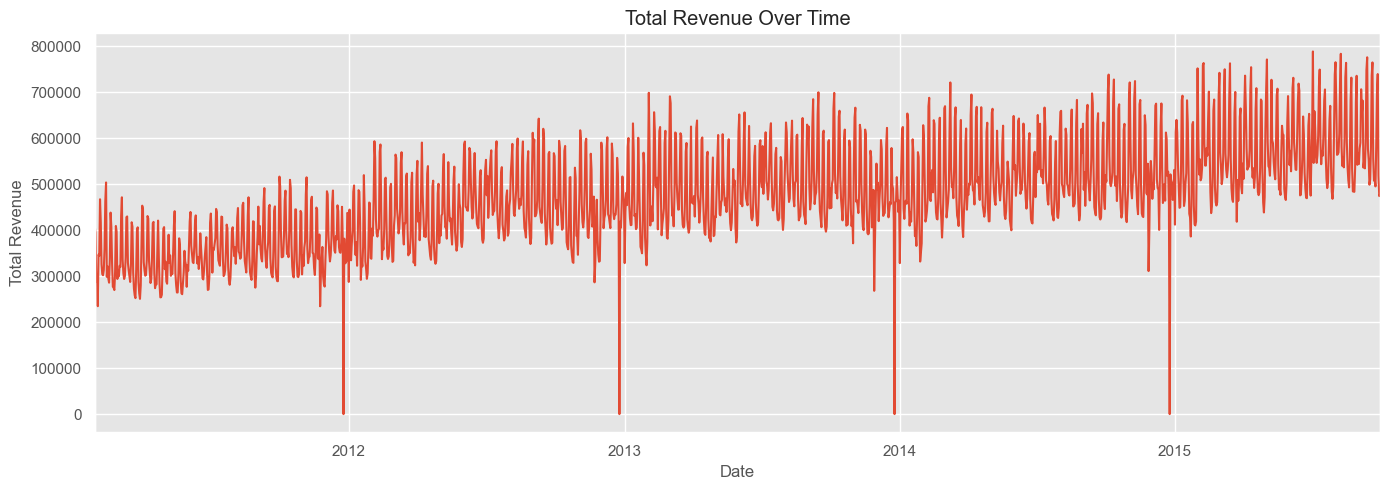

In [54]:
# Total revenue per day (across all stores)
daily_rev = train.groupby("date")["revenue"].sum()

plt.figure(figsize=(14, 5))
daily_rev.plot()
plt.title("Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()


REVENUE ANALYSIS

1. DESCRIPTIVE STATISTICS
------------------------------
Count:           18,766
Mean:            $43,101.36
Median:          $23,064.68
Std Dev:         $64,141.03
Min:             $0.00
Max:             $394,304.00
Range:           $394,304.00
Coefficient of Variation: 1.488

25th Percentile: $17,746.47
75th Percentile: $31,238.13
95th Percentile: $227,220.09
99th Percentile: $308,203.40

2. DISTRIBUTION ANALYSIS
------------------------------
Skewness:        3.081 (Right-skewed)
Kurtosis:        8.501 (Heavy-tailed)

3. OUTLIER DETECTION
------------------------------
Outliers (IQR):  1,920 (10.2%)
Lower Bound:     $-2,491.02
Upper Bound:     $51,475.63

Zero Revenue:    21 (0.1%)
Negative Revenue: 0 (0.0%)


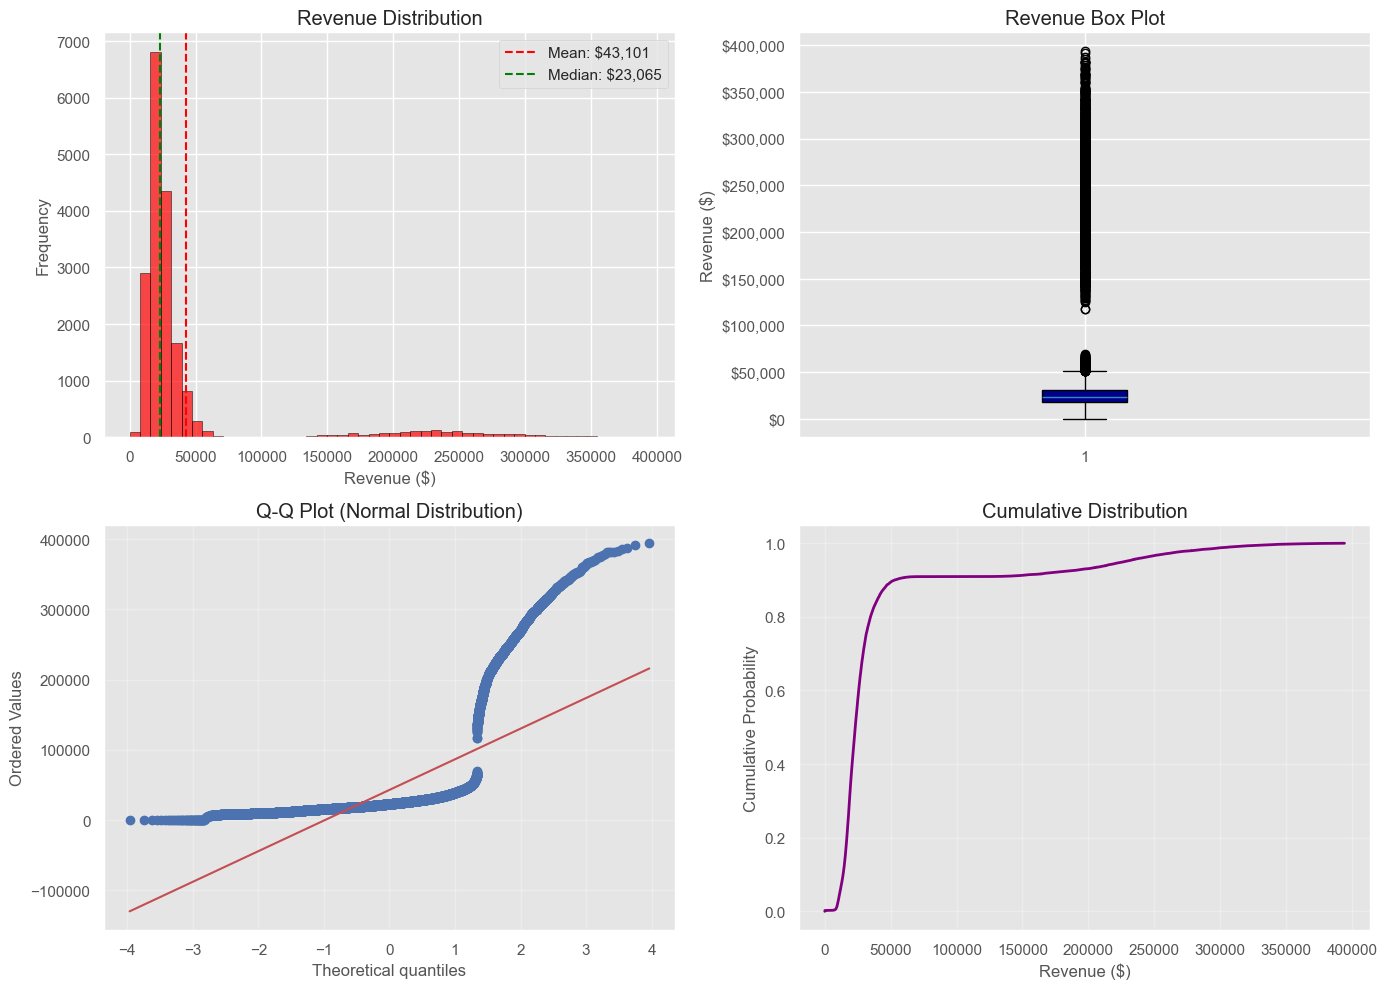


4. REVENUE BANDS
------------------------------
Low (0-25%): 4,692 (25.0%)
Medium-Low (25-50%): 4,691 (25.0%)
Medium-High (50-75%): 4,691 (25.0%)
High (75-100%): 4,692 (25.0%)

5. KEY INSIGHTS
------------------------------
1. Revenue is highly right-skewed - few very high revenue days
2. High number of outliers (10.2%) - investigate extreme values
3. High revenue variability - inconsistent performance
4. Found 21 days with zero revenue


In [55]:
def analyze_revenue(df):
    """
    Focused analysis of the revenue column
    """
    
    print("REVENUE ANALYSIS")
    print("="*50)
    
    # Basic Statistics
    print("\n1. DESCRIPTIVE STATISTICS")
    print("-" * 30)
    print(f"Count:           {df['revenue'].count():,}")
    print(f"Mean:            ${df['revenue'].mean():,.2f}")
    print(f"Median:          ${df['revenue'].median():,.2f}")
    print(f"Std Dev:         ${df['revenue'].std():,.2f}")
    print(f"Min:             ${df['revenue'].min():,.2f}")
    print(f"Max:             ${df['revenue'].max():,.2f}")
    print(f"Range:           ${df['revenue'].max() - df['revenue'].min():,.2f}")
    print(f"Coefficient of Variation: {df['revenue'].std() / df['revenue'].mean():.3f}")
    
    # Percentiles
    print(f"\n25th Percentile: ${df['revenue'].quantile(0.25):,.2f}")
    print(f"75th Percentile: ${df['revenue'].quantile(0.75):,.2f}")
    print(f"95th Percentile: ${df['revenue'].quantile(0.95):,.2f}")
    print(f"99th Percentile: ${df['revenue'].quantile(0.99):,.2f}")
    
    # Distribution Analysis
    print("\n2. DISTRIBUTION ANALYSIS")
    print("-" * 30)
    skewness = df['revenue'].skew()
    kurtosis = df['revenue'].kurtosis()
    print(f"Skewness:        {skewness:.3f} {'(Right-skewed)' if skewness > 0.5 else '(Left-skewed)' if skewness < -0.5 else '(Nearly symmetric)'}")
    print(f"Kurtosis:        {kurtosis:.3f} {'(Heavy-tailed)' if kurtosis > 3 else '(Light-tailed)' if kurtosis < 3 else '(Normal-tailed)'}")
    
    # Outlier Detection
    print("\n3. OUTLIER DETECTION")
    print("-" * 30)
    Q1 = df['revenue'].quantile(0.25)
    Q3 = df['revenue'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['revenue'] < lower_bound) | (df['revenue'] > upper_bound)]
    print(f"Outliers (IQR):  {len(outliers):,} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"Lower Bound:     ${lower_bound:,.2f}")
    print(f"Upper Bound:     ${upper_bound:,.2f}")
    
    # Zero/Negative Revenue Check
    zero_revenue = (df['revenue'] == 0).sum()
    negative_revenue = (df['revenue'] < 0).sum()
    print(f"\nZero Revenue:    {zero_revenue:,} ({zero_revenue/len(df)*100:.1f}%)")
    print(f"Negative Revenue: {negative_revenue:,} ({negative_revenue/len(df)*100:.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram
    axes[0,0].hist(df['revenue'], bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0,0].axvline(df['revenue'].mean(), color='red', linestyle='--', label=f'Mean: ${df["revenue"].mean():,.0f}')
    axes[0,0].axvline(df['revenue'].median(), color='green', linestyle='--', label=f'Median: ${df["revenue"].median():,.0f}')
    axes[0,0].set_title('Revenue Distribution')
    axes[0,0].set_xlabel('Revenue ($)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # Box Plot
    axes[0,1].boxplot(df['revenue'], patch_artist=True, boxprops=dict(facecolor='darkblue'))
    axes[0,1].set_title('Revenue Box Plot')
    axes[0,1].set_ylabel('Revenue ($)')
    axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Q-Q Plot
    stats.probplot(df['revenue'], dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Normal Distribution)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Log Distribution (if all positive)
    if df['revenue'].min() > 0:
        axes[1,1].hist(np.log(df['revenue']), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1,1].set_title('Log Revenue Distribution')
        axes[1,1].set_xlabel('Log(Revenue)')
        axes[1,1].set_ylabel('Frequency')
    else:
        # Cumulative Distribution
        sorted_revenue = np.sort(df['revenue'])
        cumulative_prob = np.arange(1, len(sorted_revenue) + 1) / len(sorted_revenue)
        axes[1,1].plot(sorted_revenue, cumulative_prob, linewidth=2, color='purple')
        axes[1,1].set_title('Cumulative Distribution')
        axes[1,1].set_xlabel('Revenue ($)')
        axes[1,1].set_ylabel('Cumulative Probability')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Revenue Bands Analysis
    print("\n4. REVENUE BANDS")
    print("-" * 30)
    
    # Create revenue bands
    revenue_bands = pd.cut(df['revenue'], 
                          bins=[df['revenue'].min()-1, df['revenue'].quantile(0.25), 
                               df['revenue'].quantile(0.5), df['revenue'].quantile(0.75), 
                               df['revenue'].max()],
                          labels=['Low (0-25%)', 'Medium-Low (25-50%)', 
                                 'Medium-High (50-75%)', 'High (75-100%)'])
    
    band_counts = revenue_bands.value_counts().sort_index()
    for band, count in band_counts.items():
        print(f"{band}: {count:,} ({count/len(df)*100:.1f}%)")
    
    # Summary Insights
    print("\n5. KEY INSIGHTS")
    print("-" * 30)
    
    insights = []
    
    if skewness > 1:
        insights.append("Revenue is highly right-skewed - few very high revenue days")
    elif skewness > 0.5:
        insights.append("Revenue is moderately right-skewed")
    
    if len(outliers) / len(df) > 0.05:
        insights.append(f"High number of outliers ({len(outliers)/len(df)*100:.1f}%) - investigate extreme values")
    
    cv = df['revenue'].std() / df['revenue'].mean()
    if cv > 0.5:
        insights.append("High revenue variability - inconsistent performance")
    elif cv < 0.2:
        insights.append("Low revenue variability - consistent performance")
    
    if zero_revenue > 0:
        insights.append(f"Found {zero_revenue} days with zero revenue")
    
    if negative_revenue > 0:
        insights.append(f"Found {negative_revenue} days with negative revenue - check for returns/refunds")
    
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    if not insights:
        print("Revenue distribution appears normal with no major issues detected.")
    
    return {
        'mean': df['revenue'].mean(),
        'median': df['revenue'].median(),
        'std': df['revenue'].std(),
        'skewness': skewness,
        'outliers_count': len(outliers),
        'outliers_pct': len(outliers)/len(df)*100
    }

# Usage:
stats = analyze_revenue(train)

Creating individual timeline plots for 11 stores...


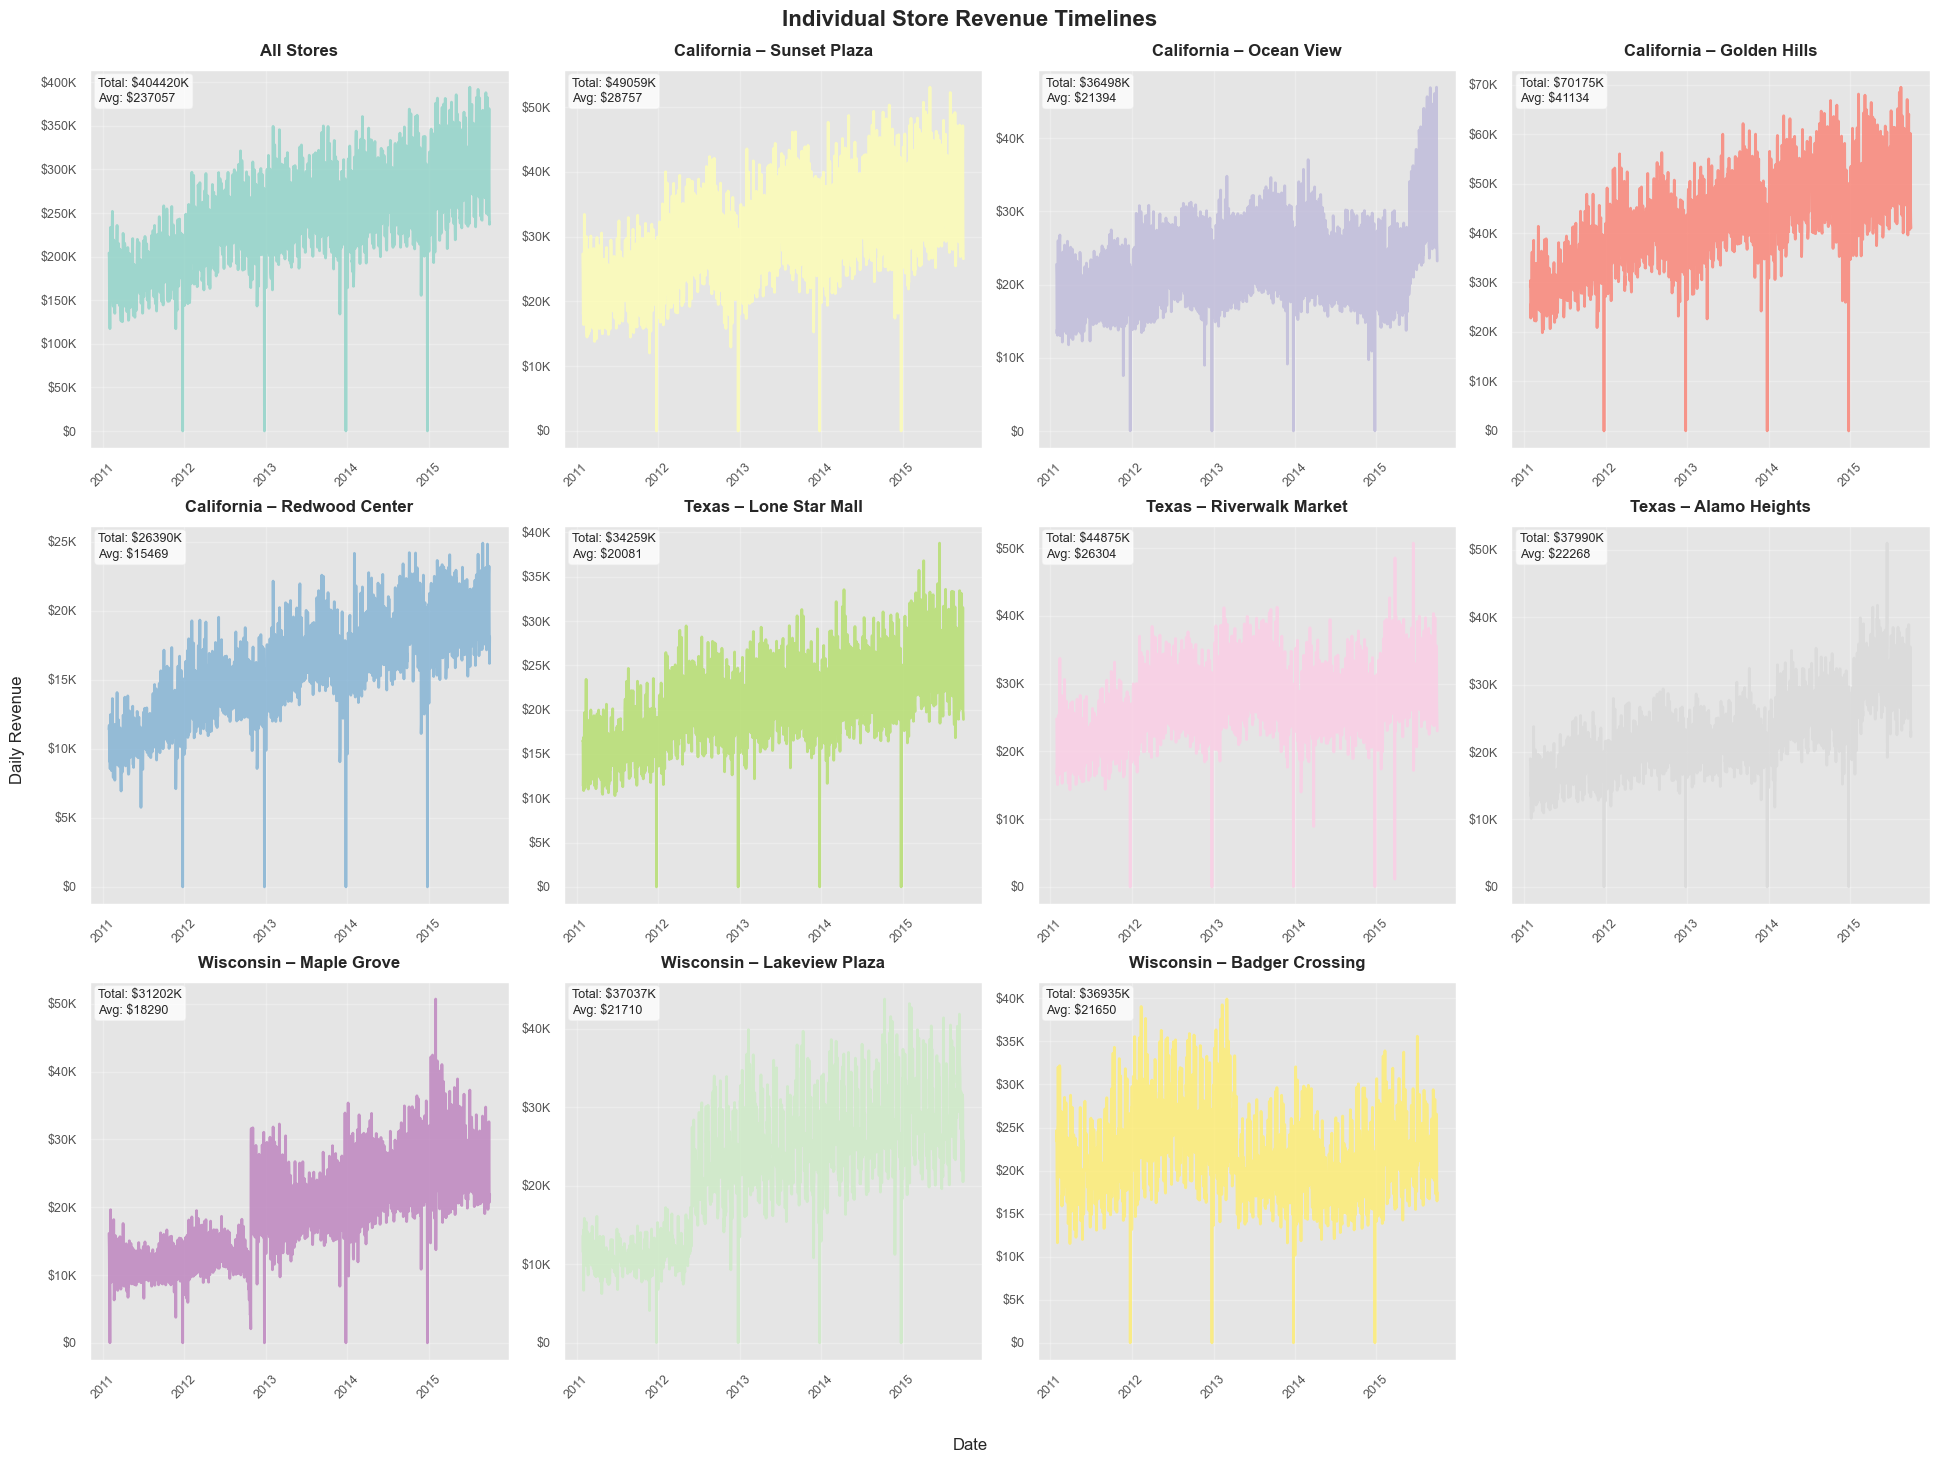


Displayed 11 individual store timelines in 3x4 grid
Plotting revenue timeline for 11 stores...
Legend hidden due to large number of stores (11). Set show_legend=False to suppress this message.


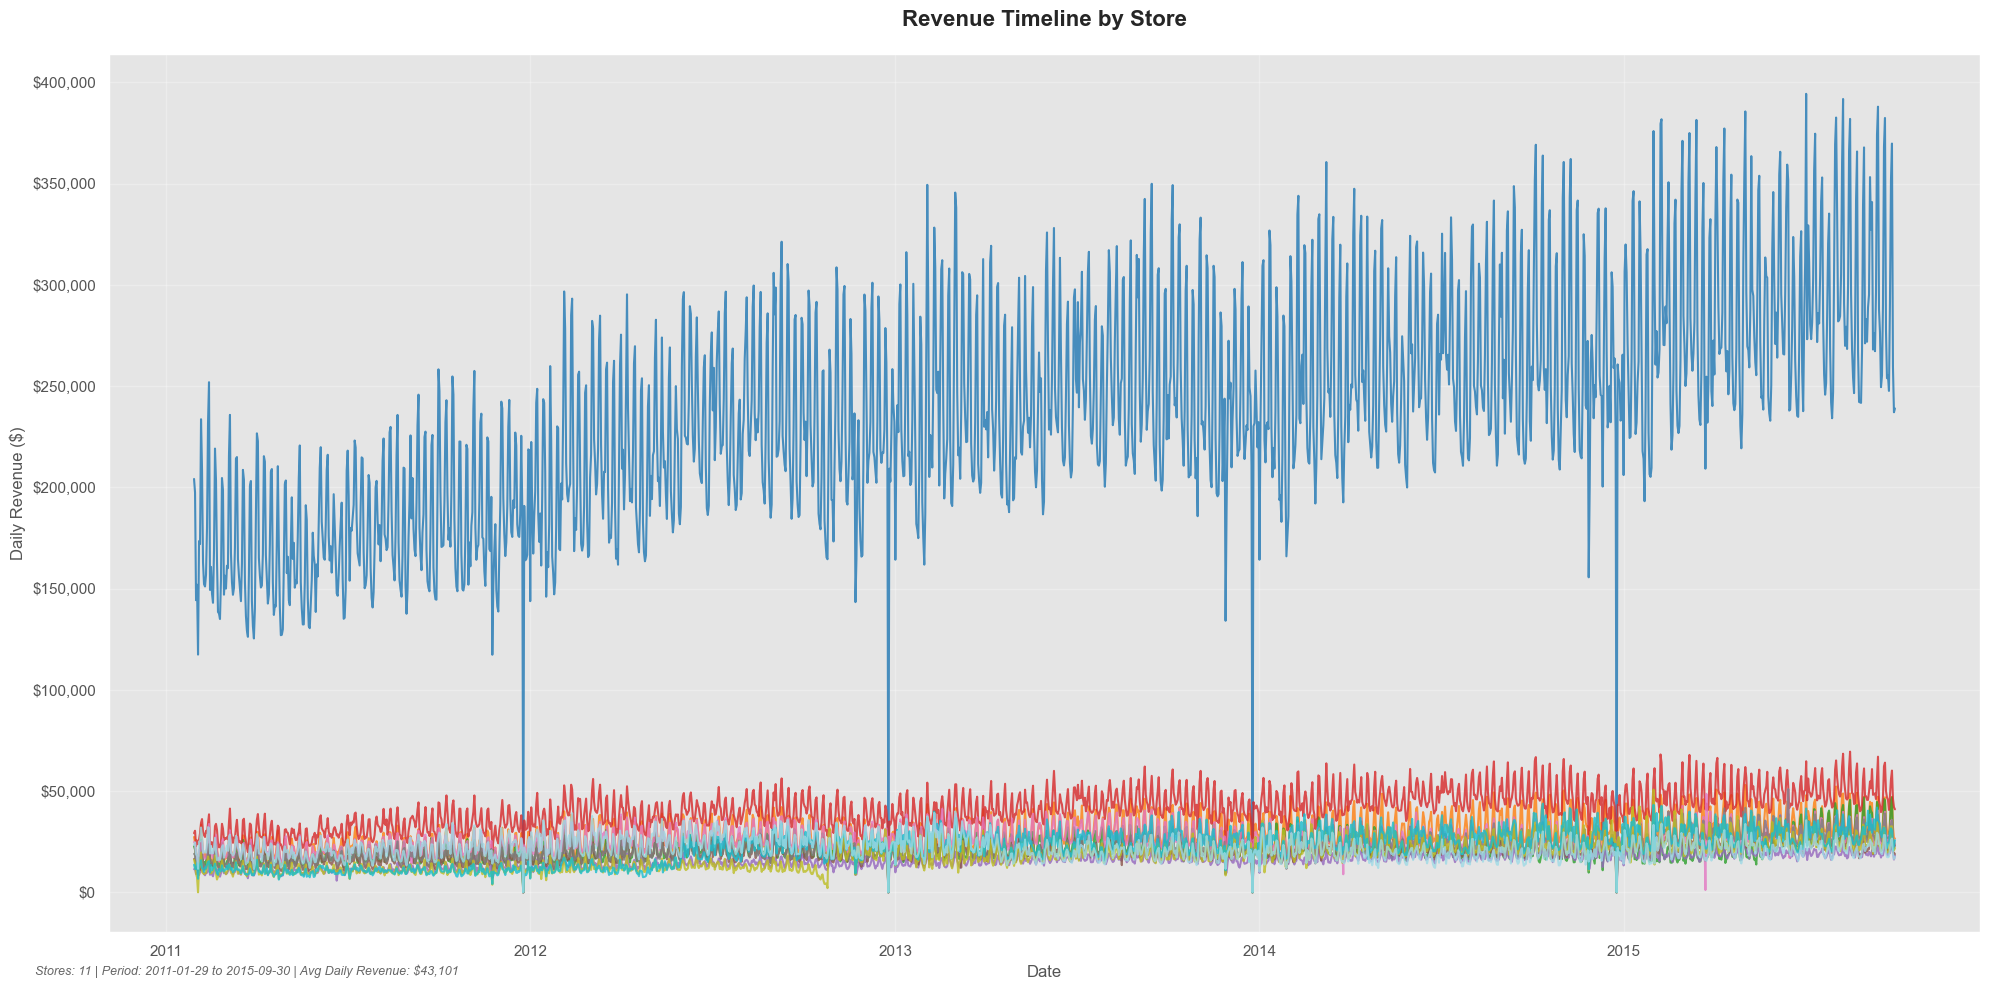


Store Performance Summary:
--------------------------------------------------
Store Name                Total Revenue   Avg Daily    Days   Max Daily   
----------------------------------------------------------------------
All Stores                $ 404,420,015 $  237,057 1706 $  394,304
California – Golden Hills $  70,175,191 $   41,134 1706 $   69,467
California – Sunset Plaza $  49,059,268 $   28,757 1706 $   53,079
Texas – Riverwalk Market  $  44,874,692 $   26,304 1706 $   50,754
Texas – Alamo Heights     $  37,989,882 $   22,268 1706 $   50,970
Wisconsin – Lakeview Plaza $  37,037,117 $   21,710 1706 $   43,799
Wisconsin – Badger Crossing $  36,935,394 $   21,650 1706 $   39,917
California – Ocean View   $  36,497,502 $   21,394 1706 $   46,946
Texas – Lone Star Mall    $  34,258,610 $   20,081 1706 $   38,791
Wisconsin – Maple Grove   $  31,201,982 $   18,290 1706 $   50,716
... and 1 more stores


,Total_Revenue,Avg_Daily_Revenue,Days_Active,Max_Daily_Revenue
store_name,,,,
All Stores,4.044200e+08,237057.45,1706,394304.00
California – Golden Hills,7.017519e+07,41134.34,1706,69466.55
California – Sunset Plaza,4.905927e+07,28756.90,1706,53079.07
Texas – Riverwalk Market,4.487469e+07,26304.04,1706,50754.12
Texas – Alamo Heights,3.798988e+07,22268.39,1706,50970.07
Wisconsin – Lakeview Plaza,3.703712e+07,21709.92,1706,43798.95
Wisconsin – Badger Crossing,3.693539e+07,21650.29,1706,39917.35
California – Ocean View,3.649750e+07,21393.61,1706,46946.10
Texas – Lone Star Mall,3.425861e+07,20081.25,1706,38790.60


In [56]:
def plot_store_revenue_timeline(df, figsize=(16, 8), show_legend=True, legend_outside=True):
    """
    Plot revenue timeline for all stores in one figure
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: store_name, date, revenue
    figsize : tuple
        Figure size (width, height)
    show_legend : bool
        Whether to show legend
    legend_outside : bool
        Whether to place legend outside the plot area
    """
    
    plt.figure(figsize=figsize)
    
    # Get unique stores
    unique_stores = df['store_name'].unique()
    n_stores = len(unique_stores)
    
    print(f"Plotting revenue timeline for {n_stores} stores...")
    
    # Use a color palette with enough colors
    colors = plt.cm.tab20(np.linspace(0, 1, n_stores)) if n_stores <= 20 else plt.cm.tab20c(np.linspace(0, 1, n_stores))
    
    # Plot each store
    for i, store in enumerate(unique_stores):
        store_df = df[df['store_name'] == store]
        daily_revenue = store_df.groupby("date")["revenue"].sum()
        
        plt.plot(daily_revenue.index, daily_revenue.values, 
                label=store, color=colors[i], linewidth=1.5, alpha=0.8)
    
    # Formatting
    plt.title("Revenue Timeline by Store", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Daily Revenue ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format y-axis to show currency
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Legend handling
    if show_legend:
        if legend_outside and n_stores > 10:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        elif n_stores <= 10:
            plt.legend(fontsize=10)
        else:
            print(f"Legend hidden due to large number of stores ({n_stores}). Set show_legend=False to suppress this message.")
    
    # Adjust layout
    if legend_outside and show_legend and n_stores > 10:
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
    else:
        plt.tight_layout()
    
    # Add summary statistics
    total_stores = n_stores
    date_range = f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}"
    avg_daily_revenue = df.groupby(['date', 'store_name'])['revenue'].sum().mean()
    
    plt.figtext(0.02, 0.02, 
                f"Stores: {total_stores} | Period: {date_range} | Avg Daily Revenue: ${avg_daily_revenue:,.0f}", 
                fontsize=9, style='italic', alpha=0.7)
    
    plt.show()
    
    # Print store performance summary
    print("\nStore Performance Summary:")
    print("-" * 50)
    
    store_summary = df.groupby('store_name')['revenue'].agg([
        ('Total_Revenue', 'sum'),
        ('Avg_Daily_Revenue', 'mean'),
        ('Days_Active', 'count'),
        ('Max_Daily_Revenue', 'max')
    ]).round(2)
    
    store_summary = store_summary.sort_values('Total_Revenue', ascending=False)
    
    print(f"{'Store Name':<25} {'Total Revenue':<15} {'Avg Daily':<12} {'Days':<6} {'Max Daily':<12}")
    print("-" * 70)
    
    for store, row in store_summary.head(10).iterrows():
        print(f"{store:<25} ${row['Total_Revenue']:>12,.0f} ${row['Avg_Daily_Revenue']:>9,.0f} {row['Days_Active']:>4.0f} ${row['Max_Daily_Revenue']:>9,.0f}")
    
    if len(store_summary) > 10:
        print(f"... and {len(store_summary) - 10} more stores")
    
    return store_summary




def plot_individual_store_timelines(df, figsize=(20, 15)):
    """
    Create a subplot grid with individual revenue timeline for each store
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: store_name, date, revenue
    figsize : tuple
        Figure size (width, height)
    """
    
    # Get unique stores
    unique_stores = df['store_name'].unique()
    n_stores = len(unique_stores)
    
    print(f"Creating individual timeline plots for {n_stores} stores...")
    
    # Calculate grid dimensions
    # For 11 stores: 3x4 grid (12 subplots, 1 empty)
    cols = 4 if n_stores > 8 else 3 if n_stores > 4 else 2
    rows = int(np.ceil(n_stores / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easier indexing
    if n_stores == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    # Get color palette
    colors = plt.cm.Set3(np.linspace(0, 1, n_stores))
    
    # Plot each store in its own subplot
    for i, store in enumerate(unique_stores):
        store_df = df[df['store_name'] == store]
        daily_revenue = store_df.groupby("date")["revenue"].sum()
        
        ax = axes[i]
        ax.plot(daily_revenue.index, daily_revenue.values, 
               color=colors[i], linewidth=2, alpha=0.8)
        
        # Formatting for each subplot
        ax.set_title(f"{store}", fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)
        
        # Format y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K' if x >= 1000 else f'${x:.0f}'))
        
        # Add basic stats as text
        total_revenue = daily_revenue.sum()
        avg_revenue = daily_revenue.mean()
        ax.text(0.02, 0.98, f'Total: ${total_revenue/1000:.0f}K\nAvg: ${avg_revenue:.0f}', 
               transform=ax.transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Hide empty subplots
    for i in range(n_stores, len(axes)):
        axes[i].axis('off')
    
    # Main title
    fig.suptitle('Individual Store Revenue Timelines', fontsize=16, fontweight='bold', y=0.98)
    
    # Add common labels
    fig.text(0.5, 0.02, 'Date', ha='center', fontsize=12)
    fig.text(0.02, 0.5, 'Daily Revenue', va='center', rotation='vertical', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, bottom=0.08, left=0.06, right=0.98)
    plt.show()
    
    # Print summary
    print(f"\nDisplayed {n_stores} individual store timelines in {rows}x{cols} grid")
    return fig




# Plot individual timelines for each store (new function)
plot_individual_store_timelines(train)

# Plot all stores with custom settings
plot_store_revenue_timeline(train, figsize=(20, 10), legend_outside=False)


### Time & Date Analysis

SEASONALITY AND WEEKDAY EFFECTS ANALYSIS

1. WEEKDAY EFFECTS
----------------------------------------
Revenue Statistics by Day of Week:
Day        Count  Mean         Median       Std Dev      Min        Max         
--------------------------------------------------------------------------------
Monday     244    $456,340     $461,303     $83,662      $281,714   $703,227    
Tuesday    244    $417,397     $426,247     $78,589      $124       $566,113    
Wednesday  244    $412,804     $423,146     $80,464      $172       $582,912    
Thursday   243    $413,383     $419,548     $79,994      $189       $650,508    
Friday     243    $472,275     $481,864     $79,311      $304,195   $788,608    
Saturday   244    $572,438     $588,880     $93,416      $337,784   $759,082    
Sunday     244    $573,912     $591,198     $109,712     $118       $783,532    

Weekday Effects (% difference from average of $474,115):
Monday    :  -3.7% ↓
Tuesday   : -12.0% ↓
Wednesday : -12.9% ↓
Thursday  : -

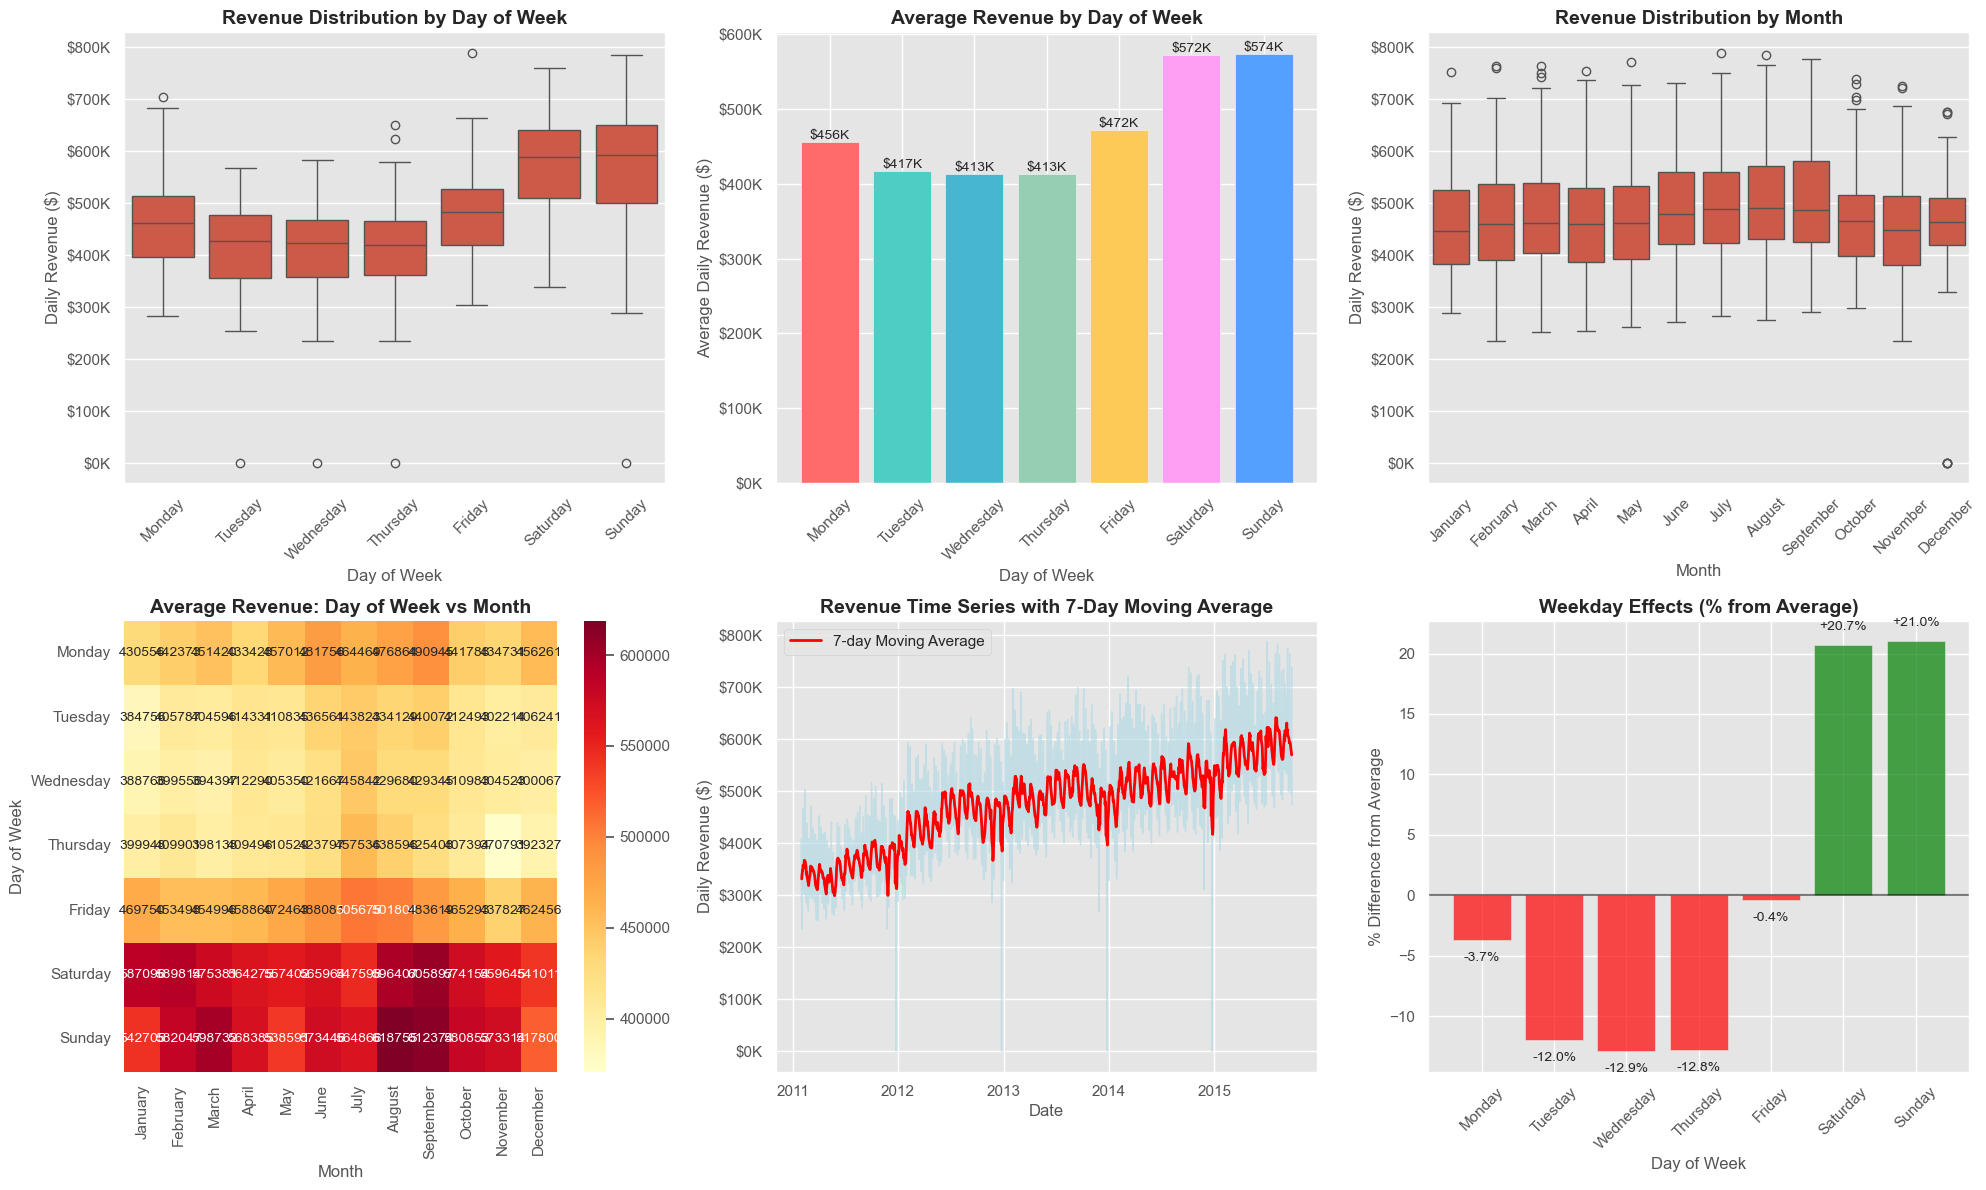



5. KEY INSIGHTS AND RECOMMENDATIONS
--------------------------------------------------
Key Findings:
1. Best performing day: Sunday (+21.0% above average)
2. Worst performing day: Wednesday (-12.9% from average)
3. Weekend premium: Weekends perform +29.2% better than weekdays
4. Peak season: August (+5.6% above average)
5. Low season: December (-4.1% from average)


In [57]:
def analyze_seasonality_weekday_effects(df):
    """
    Comprehensive analysis of seasonality and weekday effects on store revenue
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: store_name, date, revenue
    """
    
    # Prepare the data
    df_analysis = df.copy()
    df_analysis['date'] = pd.to_datetime(df_analysis['date'])
    
    # Extract time components
    df_analysis['year'] = df_analysis['date'].dt.year
    df_analysis['month'] = df_analysis['date'].dt.month
    df_analysis['month_name'] = df_analysis['date'].dt.month_name()
    df_analysis['day_of_week'] = df_analysis['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_analysis['day_name'] = df_analysis['date'].dt.day_name()
    df_analysis['quarter'] = df_analysis['date'].dt.quarter
    df_analysis['week_of_year'] = df_analysis['date'].dt.isocalendar().week
    
    # Aggregate daily revenue across all stores
    daily_agg = df_analysis.groupby('date').agg({
        'revenue': 'sum',
        'year': 'first',
        'month': 'first',
        'month_name': 'first',
        'day_of_week': 'first',
        'day_name': 'first',
        'quarter': 'first',
        'week_of_year': 'first'
    }).reset_index()
    
    print("SEASONALITY AND WEEKDAY EFFECTS ANALYSIS")
    print("=" * 60)
    
    # =====================================
    # 1. WEEKDAY EFFECTS ANALYSIS
    # =====================================
    print("\n1. WEEKDAY EFFECTS")
    print("-" * 40)
    
    # Calculate weekday statistics
    weekday_stats = daily_agg.groupby('day_name')['revenue'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    # Order by weekday
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = weekday_stats.reindex(day_order)
    
    print("Revenue Statistics by Day of Week:")
    print(f"{'Day':<10} {'Count':<6} {'Mean':<12} {'Median':<12} {'Std Dev':<12} {'Min':<10} {'Max':<12}")
    print("-" * 80)
    
    for day, stats in weekday_stats.iterrows():
        print(f"{day:<10} {stats['count']:<6.0f} ${stats['mean']:<11,.0f} ${stats['median']:<11,.0f} "
              f"${stats['std']:<11,.0f} ${stats['min']:<9,.0f} ${stats['max']:<11,.0f}")
    
    # Calculate weekday effect (percentage difference from overall mean)
    overall_mean = daily_agg['revenue'].mean()
    weekday_effects = ((weekday_stats['mean'] - overall_mean) / overall_mean * 100).round(1)
    
    print(f"\nWeekday Effects (% difference from average of ${overall_mean:,.0f}):")
    for day, effect in weekday_effects.items():
        direction = "↑" if effect > 0 else "↓" if effect < 0 else "→"
        print(f"{day:<10}: {effect:>+5.1f}% {direction}")
    
    # =====================================
    # 2. MONTHLY SEASONALITY ANALYSIS
    # =====================================
    print("\n\n2. MONTHLY SEASONALITY")
    print("-" * 40)
    
    # Calculate monthly statistics
    monthly_stats = daily_agg.groupby('month_name')['revenue'].agg([
        'count', 'mean', 'median', 'std'
    ]).round(2)
    
    # Order by month
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    monthly_stats = monthly_stats.reindex(month_order)
    monthly_stats = monthly_stats.dropna()  # Remove months not in data
    
    print("Revenue Statistics by Month:")
    print(f"{'Month':<12} {'Count':<6} {'Mean':<12} {'Median':<12} {'Std Dev':<12}")
    print("-" * 60)
    
    for month, stats in monthly_stats.iterrows():
        print(f"{month:<12} {stats['count']:<6.0f} ${stats['mean']:<11,.0f} "
              f"${stats['median']:<11,.0f} ${stats['std']:<11,.0f}")
    
    # Calculate seasonal effects
    monthly_effects = ((monthly_stats['mean'] - overall_mean) / overall_mean * 100).round(1)
    
    print(f"\nSeasonal Effects (% difference from average):")
    for month, effect in monthly_effects.items():
        direction = "↑" if effect > 0 else "↓" if effect < 0 else "→"
        print(f"{month:<12}: {effect:>+5.1f}% {direction}")
    
    # =====================================
    # 3. QUARTERLY ANALYSIS
    # =====================================
    print("\n\n3. QUARTERLY ANALYSIS")
    print("-" * 40)
    
    quarterly_stats = daily_agg.groupby('quarter')['revenue'].agg([
        'count', 'mean', 'sum'
    ]).round(2)
    
    print("Revenue by Quarter:")
    for quarter, stats in quarterly_stats.iterrows():
        print(f"Q{quarter}: Total ${stats['sum']:,.0f} | Avg Daily ${stats['mean']:,.0f} | Days: {stats['count']:.0f}")
    
    # =====================================
    # 4. VISUALIZATIONS
    # =====================================
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Weekday Revenue Box Plot
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.boxplot(data=daily_agg, x='day_name', y='revenue', order=weekday_order, ax=axes[0,0])
    axes[0,0].set_title('Revenue Distribution by Day of Week', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Day of Week')
    axes[0,0].set_ylabel('Daily Revenue ($)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # 2. Weekday Revenue Bar Plot (Average)
    weekday_means = daily_agg.groupby('day_name')['revenue'].mean().reindex(weekday_order)
    bars = axes[0,1].bar(weekday_means.index, weekday_means.values, 
                        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF'])
    axes[0,1].set_title('Average Revenue by Day of Week', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Average Daily Revenue ($)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'${height/1000:.0f}K', ha='center', va='bottom', fontsize=10)
    
    # 3. Monthly Revenue Box Plot
    if len(monthly_stats) > 1:
        month_order_filtered = [m for m in month_order if m in daily_agg['month_name'].values]
        sns.boxplot(data=daily_agg, x='month_name', y='revenue', order=month_order_filtered, ax=axes[0,2])
        axes[0,2].set_title('Revenue Distribution by Month', fontsize=14, fontweight='bold')
        axes[0,2].set_xlabel('Month')
        axes[0,2].set_ylabel('Daily Revenue ($)')
        axes[0,2].tick_params(axis='x', rotation=45)
        axes[0,2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    else:
        axes[0,2].text(0.5, 0.5, 'Insufficient data\nfor monthly analysis', 
                      ha='center', va='center', transform=axes[0,2].transAxes, fontsize=12)
        axes[0,2].set_title('Monthly Analysis', fontsize=14, fontweight='bold')
    
    # 4. Heatmap: Day of Week vs Month
    if len(monthly_stats) > 1 and len(daily_agg) > 30:
        pivot_data = daily_agg.pivot_table(values='revenue', index='day_name', 
                                          columns='month_name', aggfunc='mean')
        pivot_data = pivot_data.reindex(weekday_order)
        pivot_data = pivot_data.reindex(columns=month_order_filtered)
        
        sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1,0])
        axes[1,0].set_title('Average Revenue: Day of Week vs Month', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Month')
        axes[1,0].set_ylabel('Day of Week')
    else:
        axes[1,0].text(0.5, 0.5, 'Insufficient data\nfor heatmap analysis', 
                      ha='center', va='center', transform=axes[1,0].transAxes, fontsize=12)
        axes[1,0].set_title('Day vs Month Heatmap', fontsize=14, fontweight='bold')
    
    # 5. Time Series with Trend
    axes[1,1].plot(daily_agg['date'], daily_agg['revenue'], alpha=0.6, color='lightblue', linewidth=1)
    
    # Add 7-day moving average
    daily_agg['revenue_7ma'] = daily_agg['revenue'].rolling(window=7, center=True).mean()
    axes[1,1].plot(daily_agg['date'], daily_agg['revenue_7ma'], color='red', linewidth=2, label='7-day Moving Average')
    
    axes[1,1].set_title('Revenue Time Series with 7-Day Moving Average', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Daily Revenue ($)')
    axes[1,1].legend()
    axes[1,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # 6. Weekday Effects Comparison
    weekday_effects_plot = weekday_effects.reindex(weekday_order)
    colors = ['red' if x < 0 else 'green' for x in weekday_effects_plot.values]
    bars = axes[1,2].bar(weekday_effects_plot.index, weekday_effects_plot.values, color=colors, alpha=0.7)
    axes[1,2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,2].set_title('Weekday Effects (% from Average)', fontsize=14, fontweight='bold')
    axes[1,2].set_xlabel('Day of Week')
    axes[1,2].set_ylabel('% Difference from Average')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars, weekday_effects_plot.values):
        height = bar.get_height()
        axes[1,2].text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -1),
                      f'{value:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =====================================
    # 5. KEY INSIGHTS AND RECOMMENDATIONS
    # =====================================
    print("\n\n5. KEY INSIGHTS AND RECOMMENDATIONS")
    print("-" * 50)
    
    insights = []
    
    # Weekday insights
    best_day = weekday_effects.idxmax()
    worst_day = weekday_effects.idxmin()
    weekend_effect = weekday_effects[['Saturday', 'Sunday']].mean()
    weekday_effect = weekday_effects[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean()
    
    insights.append(f"Best performing day: {best_day} (+{weekday_effects[best_day]:.1f}% above average)")
    insights.append(f"Worst performing day: {worst_day} ({weekday_effects[worst_day]:+.1f}% from average)")
    
    if weekend_effect > weekday_effect:
        insights.append(f"Weekend premium: Weekends perform {weekend_effect - weekday_effect:+.1f}% better than weekdays")
    else:
        insights.append(f"Weekday strength: Weekdays perform {weekday_effect - weekend_effect:+.1f}% better than weekends")
    
    # Seasonal insights
    if len(monthly_stats) > 3:
        best_month = monthly_effects.idxmax()
        worst_month = monthly_effects.idxmin()
        insights.append(f"Peak season: {best_month} (+{monthly_effects[best_month]:.1f}% above average)")
        insights.append(f"Low season: {worst_month} ({monthly_effects[worst_month]:+.1f}% from average)")
    
    # Variability insights
    weekday_cv = weekday_stats['std'].mean() / weekday_stats['mean'].mean()
    if weekday_cv > 0.3:
        insights.append("High day-to-day variability detected - consider demand forecasting")
    
    print("Key Findings:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    
    # Return summary statistics
    return {
        'weekday_effects': weekday_effects.to_dict(),
        'monthly_effects': monthly_effects.to_dict() if len(monthly_stats) > 1 else {},
        'best_day': best_day,
        'worst_day': worst_day,
        'weekday_stats': weekday_stats,
        'monthly_stats': monthly_stats
    }

# Usage:
results = analyze_seasonality_weekday_effects(train)

Store 0 - Revenue Stats by Day of Week
           count       mean     median       std
day_name                                        
Monday       244  228170.07  230651.45  41831.23
Tuesday      244  208698.68  213123.58  39294.41
Wednesday    244  206401.96  211572.96  40232.11
Thursday     243  206691.26  209774.15  39997.21
Friday       243  236137.28  240931.93  39655.27
Saturday     244  286218.77  294439.81  46707.80
Sunday       244  286955.93  295598.86  54856.20

Store 0 - Revenue Stats by Month
            count       mean     median       std
month_name                                       
January       127  228599.69  222381.92  51082.64
February      141  234252.01  229722.62  56916.81
March         155  235123.45  230663.85  58395.35
April         150  232474.59  229528.06  55400.32
May           155  232174.03  230947.73  53781.94
June          150  242792.98  239004.91  51076.56
July          155  244509.18  243563.15  49981.59
August        155  250262.09  244945

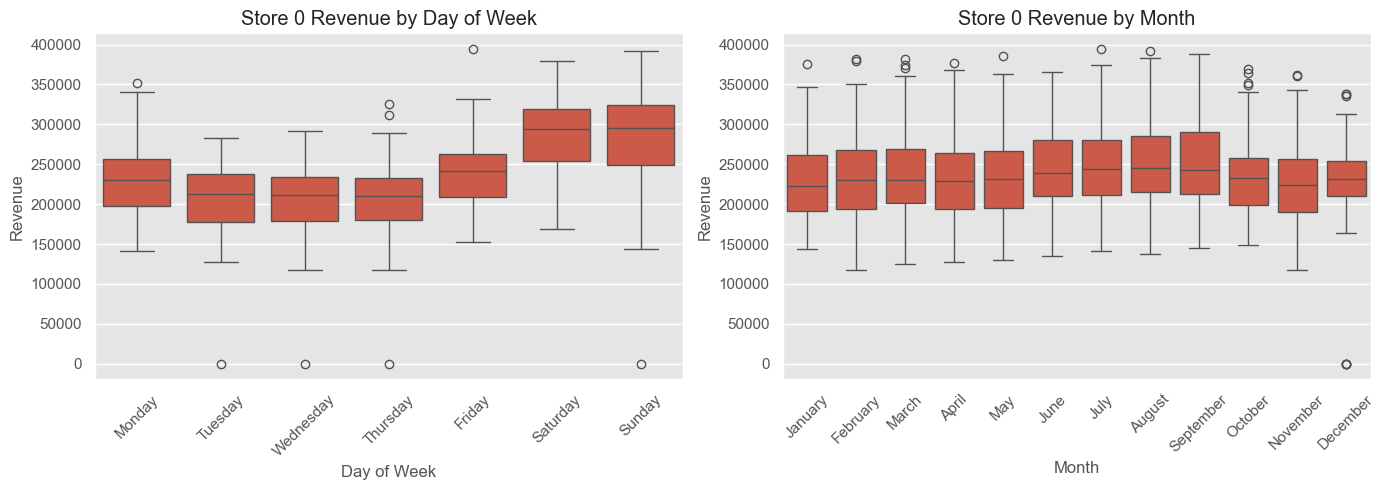

In [58]:
def analyze_spesific_store_seasonality(df, store_id):
    """
    Analyze the date-related seasonal effects (weekday, month) for a specific store.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with at least ['store_id', 'date', 'revenue'] columns.
        'date' must be datetime64[ns] type.
    store_id : int
        The store ID to analyze.
    """

    # Filter the store-specific data
    store_df = df[df['store_id'] == store_id].copy()
    store_df = store_df.sort_values('date')

    if not pd.api.types.is_datetime64_any_dtype(store_df['date']):
        store_df['date'] = pd.to_datetime(store_df['date'])

    # Extract time components
    store_df['day_of_week'] = store_df['date'].dt.dayofweek  # 0 = Monday
    store_df['day_name'] = store_df['date'].dt.day_name()
    store_df['month'] = store_df['date'].dt.month
    store_df['month_name'] = store_df['date'].dt.month_name()
    store_df['year'] = store_df['date'].dt.year

    print(f"Store {store_id} - Revenue Stats by Day of Week")
    weekday_stats = store_df.groupby('day_name')['revenue'].agg(['count', 'mean', 'median', 'std']).round(2)
    weekday_stats = weekday_stats.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    print(weekday_stats)

    print(f"\nStore {store_id} - Revenue Stats by Month")
    month_stats = store_df.groupby('month_name')['revenue'].agg(['count', 'mean', 'median', 'std']).round(2)
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    month_stats = month_stats.reindex(month_order)
    print(month_stats.dropna())

    # Plot setup
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Boxplot by day of week
    sns.boxplot(data=store_df, x='day_name', y='revenue',
                order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                ax=axes[0])
    axes[0].set_title(f"Store {store_id} Revenue by Day of Week")
    axes[0].set_xlabel("Day of Week")
    axes[0].set_ylabel("Revenue")
    axes[0].tick_params(axis='x', rotation=45)

    # Boxplot by month
    valid_months = [m for m in month_order if m in store_df['month_name'].unique()]
    sns.boxplot(data=store_df, x='month_name', y='revenue',
                order=valid_months,
                ax=axes[1])
    axes[1].set_title(f"Store {store_id} Revenue by Month")
    axes[1].set_xlabel("Month")
    axes[1].set_ylabel("Revenue")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Store level analysis for date and time   
analyze_spesific_store_seasonality(train, store_id=0)

### Calender & Events effect

CALENDAR EVENTS ANALYSIS

1. CALENDAR EVENT OVERVIEW
----------------------------------------
Total Records: 18,766
Records with Events: 1,507 (8.0%)
Records without Events: 17,259 (92.0%)
Unique Events: 34

Event Frequency (Top 15):
Event                          Count    % of Event Days
-------------------------------------------------------
SuperBowl                      55       3.6           %
Mother's day                   55       3.6           %
EidAlAdha                      55       3.6           %
LaborDay                       55       3.6           %
ValentinesDay                  55       3.6           %
Ramadan starts                 55       3.6           %
IndependenceDay                55       3.6           %
NBAFinalsStart                 55       3.6           %
MemorialDay                    55       3.6           %
Eid al-Fitr                    55       3.6           %
Purim End                      55       3.6           %
StPatricksDay                  55     

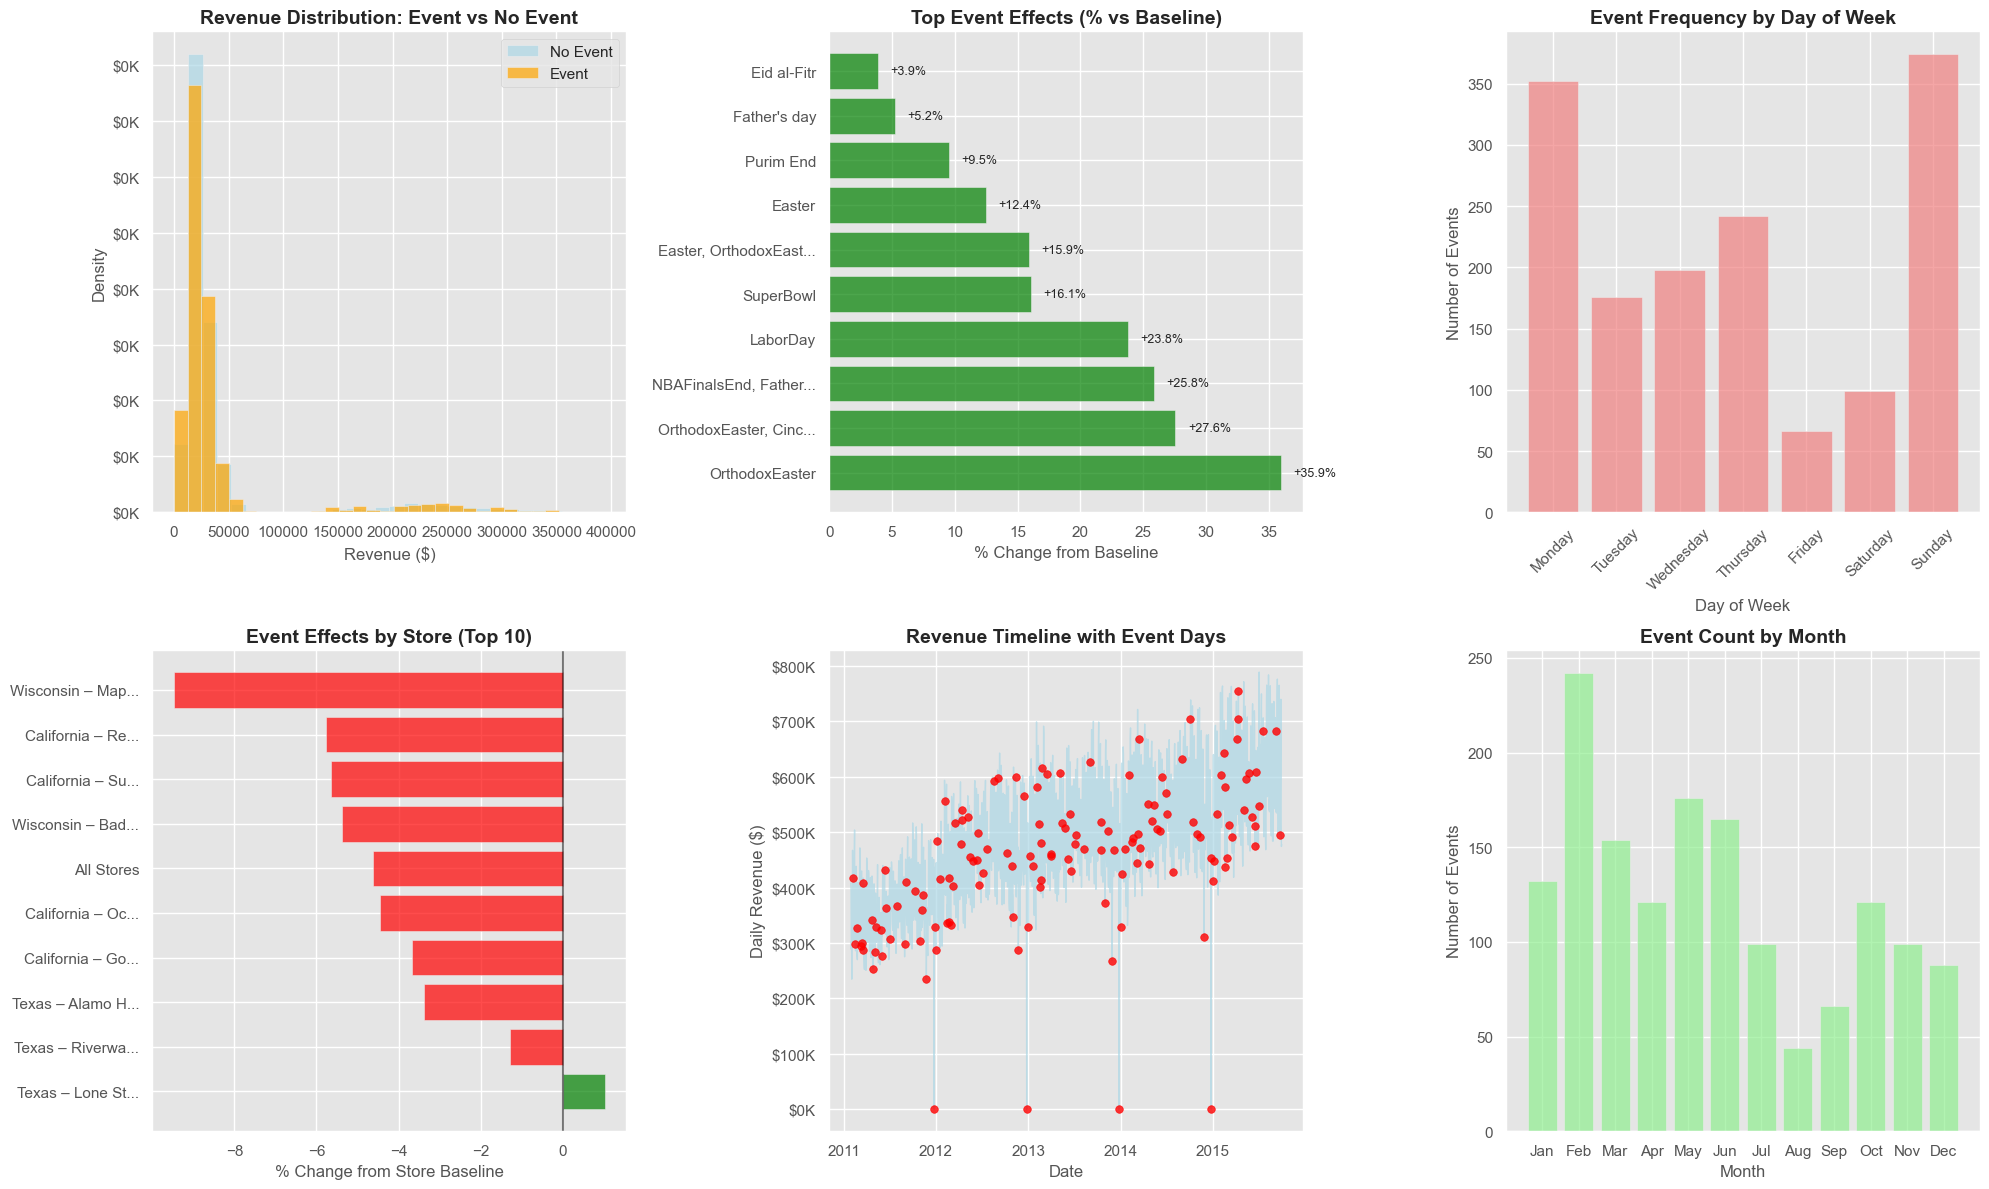



7. KEY INSIGHTS AND RECOMMENDATIONS
--------------------------------------------------
Key Findings:
1. Overall event impact: -4.6% change from baseline revenue
2. Best performing event: OrthodoxEaster (+35.9%)
3. Worst performing event: Christmas (-100.0%)
4. Average events per month: 125.6


In [59]:

import pandas as pd
import seaborn as sns
from datetime import timedelta
import calendar
import warnings
warnings.filterwarnings('ignore')

def analyze_calendar_effects(df, calendar_col='event', min_event_occurrences=3):
    """
    Comprehensive analysis of calendar events and their effects on store revenue
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: store_name, date, revenue, and calendar_col
    calendar_col : str
        Name of the column containing calendar events/holidays
    min_event_occurrences : int
        Minimum number of occurrences required for an event to be analyzed
    """
    
    # Prepare the data
    df_analysis = df.copy()
    df_analysis['date'] = pd.to_datetime(df_analysis['date'])
    
    # Extract time components
    df_analysis['year'] = df_analysis['date'].dt.year
    df_analysis['month'] = df_analysis['date'].dt.month
    df_analysis['day_of_week'] = df_analysis['date'].dt.dayofweek
    df_analysis['day_name'] = df_analysis['date'].dt.day_name()
    
    # Handle calendar events
    df_analysis['has_event'] = df_analysis[calendar_col].notna()
    df_analysis['event_clean'] = df_analysis[calendar_col].fillna('No Event')
    
    print("CALENDAR EVENTS ANALYSIS")
    print("=" * 60)
    
    # =====================================
    # 1. CALENDAR EVENT OVERVIEW
    # =====================================
    print("\n1. CALENDAR EVENT OVERVIEW")
    print("-" * 40)
    
    total_records = len(df_analysis)
    event_records = df_analysis['has_event'].sum()
    unique_events = df_analysis[df_analysis['has_event']]['event_clean'].nunique()
    
    print(f"Total Records: {total_records:,}")
    print(f"Records with Events: {event_records:,} ({event_records/total_records*100:.1f}%)")
    print(f"Records without Events: {total_records - event_records:,} ({(total_records - event_records)/total_records*100:.1f}%)")
    print(f"Unique Events: {unique_events}")
    
    # Event frequency analysis
    event_counts = df_analysis[df_analysis['has_event']]['event_clean'].value_counts()
    
    print(f"\nEvent Frequency (Top 15):")
    print(f"{'Event':<30} {'Count':<8} {'% of Event Days':<15}")
    print("-" * 55)
    
    for event, count in event_counts.head(15).items():
        pct_of_events = count / event_records * 100
        print(f"{event[:29]:<30} {count:<8} {pct_of_events:<14.1f}%")
    
    if len(event_counts) > 15:
        print(f"... and {len(event_counts) - 15} more events")
    
    # =====================================
    # 2. EVENT IMPACT ON REVENUE
    # =====================================
    print("\n\n2. EVENT IMPACT ON REVENUE")
    print("-" * 40)
    
    # Calculate baseline (no event) revenue
    baseline_revenue = df_analysis[~df_analysis['has_event']]['revenue'].mean()
    baseline_std = df_analysis[~df_analysis['has_event']]['revenue'].std()
    
    print(f"Baseline Revenue (No Event): ${baseline_revenue:,.2f} ± ${baseline_std:,.2f}")
    
    # Filter events with sufficient occurrences
    frequent_events = event_counts[event_counts >= min_event_occurrences].index.tolist()
    
    # Calculate event effects
    event_effects = {}
    
    for event in frequent_events:
        event_data = df_analysis[df_analysis['event_clean'] == event]
        
        event_stats = {
            'count': len(event_data),
            'mean_revenue': event_data['revenue'].mean(),
            'median_revenue': event_data['revenue'].median(),
            'std_revenue': event_data['revenue'].std(),
            'total_revenue': event_data['revenue'].sum(),
            'effect_vs_baseline': ((event_data['revenue'].mean() - baseline_revenue) / baseline_revenue * 100),
            'stores_affected': event_data['store_name'].nunique()
        }
        
        event_effects[event] = event_stats
    
    # Create event effects DataFrame
    effects_df = pd.DataFrame(event_effects).T
    effects_df = effects_df.sort_values('effect_vs_baseline', ascending=False)
    
    print(f"\nEvent Impact Analysis (Events with ≥{min_event_occurrences} occurrences):")
    print(f"{'Event':<25} {'Count':<6} {'Avg Revenue':<12} {'Effect vs Baseline':<18} {'Stores':<7}")
    print("-" * 75)
    
    for event, stats in effects_df.head(15).iterrows():
        effect_sign = "+" if stats['effect_vs_baseline'] > 0 else ""
        print(f"{event[:24]:<25} {stats['count']:<6.0f} ${stats['mean_revenue']:<11,.0f} "
              f"{effect_sign}{stats['effect_vs_baseline']:<17.1f}% {stats['stores_affected']:<7.0f}")
    
    # =====================================
    # 3. EVENT TIMING ANALYSIS
    # =====================================
    print("\n\n3. EVENT TIMING PATTERNS")
    print("-" * 40)
    
    # Day of week analysis for events
    event_dow = df_analysis[df_analysis['has_event']].groupby('day_name').agg({
        'revenue': ['count', 'mean'],
        'event_clean': 'nunique'
    }).round(2)
    
    event_dow.columns = ['Event_Count', 'Avg_Revenue', 'Unique_Events']
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    event_dow = event_dow.reindex(day_order).fillna(0)
    
    print("Events by Day of Week:")
    print(event_dow)
    
    # Monthly distribution of events
    if df_analysis['month'].nunique() > 1:
        monthly_events = df_analysis[df_analysis['has_event']].groupby('month').agg({
            'revenue': ['count', 'mean'],
            'event_clean': 'nunique'
        }).round(2)
        
        monthly_events.columns = ['Event_Count', 'Avg_Revenue', 'Unique_Events']
        
        print(f"\nEvents by Month:")
        for month, stats in monthly_events.iterrows():
            month_name = calendar.month_name[month]
            print(f"{month_name:<12}: {stats['Event_Count']:.0f} events, Avg Revenue: ${stats['Avg_Revenue']:,.0f}")
    
    # =====================================
    # 4. STORE-SPECIFIC EVENT ANALYSIS
    # =====================================
    print("\n\n4. STORE-SPECIFIC EVENT ANALYSIS")
    print("-" * 40)
    
    # Calculate event effects by store
    store_event_analysis = {}
    
    for store in df_analysis['store_name'].unique():
        store_data = df_analysis[df_analysis['store_name'] == store]
        
        store_baseline = store_data[~store_data['has_event']]['revenue'].mean()
        store_event_avg = store_data[store_data['has_event']]['revenue'].mean()
        
        event_effect = ((store_event_avg - store_baseline) / store_baseline * 100) if store_baseline > 0 else 0
        
        store_event_analysis[store] = {
            'baseline_revenue': store_baseline,
            'event_revenue': store_event_avg,
            'event_effect': event_effect,
            'event_days': store_data['has_event'].sum(),
            'total_days': len(store_data)
        }
    
    store_effects_df = pd.DataFrame(store_event_analysis).T
    store_effects_df = store_effects_df.sort_values('event_effect', ascending=False)
    
    print("Event Effects by Store:")
    print(f"{'Store':<25} {'Baseline':<10} {'Event Avg':<10} {'Effect':<8} {'Event Days':<11}")
    print("-" * 70)
    
    for store, stats in store_effects_df.head(10).iterrows():
        effect_sign = "+" if stats['event_effect'] > 0 else ""
        print(f"{store[:24]:<25} ${stats['baseline_revenue']:<9,.0f} ${stats['event_revenue']:<9,.0f} "
              f"{effect_sign}{stats['event_effect']:<7.1f}% {stats['event_days']:<11.0f}")
    
    # =====================================
    # 5. EVENT SEQUENCE ANALYSIS
    # =====================================
    print("\n\n5. EVENT SEQUENCE ANALYSIS")
    print("-" * 40)
    
    # Analyze revenue before, during, and after events
    sequence_analysis = {}
    
    for event in frequent_events[:5]:  # Top 5 frequent events
        event_dates = df_analysis[df_analysis['event_clean'] == event]['date'].unique()
        
        before_revenue = []
        during_revenue = []
        after_revenue = []
        
        for event_date in event_dates:
            # Before event (1-3 days before)
            before_period = df_analysis[
                (df_analysis['date'] >= event_date - timedelta(days=3)) &
                (df_analysis['date'] < event_date) &
                (~df_analysis['has_event'])
            ]['revenue']
            
            # During event
            during_period = df_analysis[
                (df_analysis['date'] == event_date) &
                (df_analysis['event_clean'] == event)
            ]['revenue']
            
            # After event (1-3 days after)
            after_period = df_analysis[
                (df_analysis['date'] > event_date) &
                (df_analysis['date'] <= event_date + timedelta(days=3)) &
                (~df_analysis['has_event'])
            ]['revenue']
            
            if len(before_period) > 0:
                before_revenue.extend(before_period.tolist())
            if len(during_period) > 0:
                during_revenue.extend(during_period.tolist())
            if len(after_period) > 0:
                after_revenue.extend(after_period.tolist())
        
        if before_revenue and during_revenue and after_revenue:
            sequence_analysis[event] = {
                'before_avg': np.mean(before_revenue),
                'during_avg': np.mean(during_revenue),
                'after_avg': np.mean(after_revenue),
                'before_effect': ((np.mean(before_revenue) - baseline_revenue) / baseline_revenue * 100),
                'during_effect': ((np.mean(during_revenue) - baseline_revenue) / baseline_revenue * 100),
                'after_effect': ((np.mean(after_revenue) - baseline_revenue) / baseline_revenue * 100)
            }
    
    if sequence_analysis:
        print("Before/During/After Event Analysis (Top 5 events):")
        print(f"{'Event':<20} {'Before':<8} {'During':<8} {'After':<8} {'Pattern':<15}")
        print("-" * 65)
        
        for event, analysis in sequence_analysis.items():
            before_eff = analysis['before_effect']
            during_eff = analysis['during_effect'] 
            after_eff = analysis['after_effect']
            
            # Determine pattern
            if during_eff > 5 and after_eff < -5:
                pattern = "Boost → Drop"
            elif during_eff > 5 and before_eff > 5:
                pattern = "Pre-event buildup"
            elif during_eff > 5:
                pattern = "Event boost"
            elif during_eff < -5:
                pattern = "Event decline"
            else:
                pattern = "Minimal impact"
            
            print(f"{event[:19]:<20} {before_eff:>+6.1f}% {during_eff:>+6.1f}% {after_eff:>+6.1f}% {pattern:<15}")
    
    # =====================================
    # 6. VISUALIZATIONS
    # =====================================
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Event vs No Event Revenue Distribution
    event_revenue = df_analysis[df_analysis['has_event']]['revenue']
    no_event_revenue = df_analysis[~df_analysis['has_event']]['revenue']
    
    axes[0,0].hist(no_event_revenue, bins=30, alpha=0.7, label='No Event', color='lightblue', density=True)
    axes[0,0].hist(event_revenue, bins=30, alpha=0.7, label='Event', color='orange', density=True)
    axes[0,0].set_title('Revenue Distribution: Event vs No Event', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Revenue ($)')
    axes[0,0].set_ylabel('Density')
    axes[0,0].legend()
    axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # 2. Top Event Effects
    top_effects = effects_df.head(10)
    colors = ['green' if x > 0 else 'red' for x in top_effects['effect_vs_baseline']]
    
    bars = axes[0,1].barh(range(len(top_effects)), top_effects['effect_vs_baseline'], color=colors, alpha=0.7)
    axes[0,1].set_title('Top Event Effects (% vs Baseline)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('% Change from Baseline')
    axes[0,1].set_yticks(range(len(top_effects)))
    axes[0,1].set_yticklabels([event[:20] + '...' if len(event) > 20 else event for event in top_effects.index])
    axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, top_effects['effect_vs_baseline'])):
        axes[0,1].text(value + (1 if value > 0 else -1), i, f'{value:+.1f}%', 
                      va='center', ha='left' if value > 0 else 'right', fontsize=9)
    
    # 3. Event Frequency by Day of Week
    event_dow_counts = df_analysis[df_analysis['has_event']]['day_name'].value_counts().reindex(day_order).fillna(0)
    
    axes[0,2].bar(event_dow_counts.index, event_dow_counts.values, color='lightcoral', alpha=0.7)
    axes[0,2].set_title('Event Frequency by Day of Week', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Day of Week')
    axes[0,2].set_ylabel('Number of Events')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Store Event Effects
    store_effects_plot = store_effects_df['event_effect'].head(10)
    colors = ['green' if x > 0 else 'red' for x in store_effects_plot]
    
    axes[1,0].barh(range(len(store_effects_plot)), store_effects_plot.values, color=colors, alpha=0.7)
    axes[1,0].set_title('Event Effects by Store (Top 10)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('% Change from Store Baseline')
    axes[1,0].set_yticks(range(len(store_effects_plot)))
    axes[1,0].set_yticklabels([store[:15] + '...' if len(store) > 15 else store for store in store_effects_plot.index])
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # 5. Revenue Timeline with Events
    daily_revenue = df_analysis.groupby('date').agg({
        'revenue': 'sum',
        'has_event': 'any'
    })
    
    # Plot revenue timeline
    axes[1,1].plot(daily_revenue.index, daily_revenue['revenue'], color='lightblue', alpha=0.7, linewidth=1)
    
    # Highlight event days
    event_days = daily_revenue[daily_revenue['has_event']]
    axes[1,1].scatter(event_days.index, event_days['revenue'], color='red', alpha=0.8, s=30, zorder=5)
    
    axes[1,1].set_title('Revenue Timeline with Event Days', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Daily Revenue ($)')
    axes[1,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # 6. Event Count by Month (if applicable)
    if df_analysis['month'].nunique() > 1:
        monthly_event_counts = df_analysis[df_analysis['has_event']]['month'].value_counts().sort_index()
        month_names = [calendar.month_abbr[m] for m in monthly_event_counts.index]
        
        axes[1,2].bar(month_names, monthly_event_counts.values, color='lightgreen', alpha=0.7)
        axes[1,2].set_title('Event Count by Month', fontsize=14, fontweight='bold')
        axes[1,2].set_xlabel('Month')
        axes[1,2].set_ylabel('Number of Events')
    else:
        axes[1,2].text(0.5, 0.5, 'Insufficient data\nfor monthly analysis', 
                      ha='center', va='center', transform=axes[1,2].transAxes, fontsize=12)
        axes[1,2].set_title('Monthly Event Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # =====================================
    # 7. KEY INSIGHTS AND RECOMMENDATIONS
    # =====================================
    print("\n\n7. KEY INSIGHTS AND RECOMMENDATIONS")
    print("-" * 50)
    
    insights = []
    
    # Overall event impact
    overall_event_effect = ((event_revenue.mean() - baseline_revenue) / baseline_revenue * 100)
    insights.append(f"Overall event impact: {overall_event_effect:+.1f}% change from baseline revenue")
    
    # Best and worst events
    if not effects_df.empty:
        best_event = effects_df.index[0]
        best_effect = effects_df.iloc[0]['effect_vs_baseline']
        worst_event = effects_df.index[-1]
        worst_effect = effects_df.iloc[-1]['effect_vs_baseline']
        
        insights.append(f"Best performing event: {best_event} (+{best_effect:.1f}%)")
        insights.append(f"Worst performing event: {worst_event} ({worst_effect:+.1f}%)")
    
    # Store variability
    store_effect_std = store_effects_df['event_effect'].std()
    if store_effect_std > 10:
        insights.append(f"High variation in event effects across stores (std: {store_effect_std:.1f}%) - consider store-specific strategies")
    
    # Event frequency insights
    avg_events_per_month = event_records / df_analysis['month'].nunique() if df_analysis['month'].nunique() > 0 else 0
    insights.append(f"Average events per month: {avg_events_per_month:.1f}")
    
    print("Key Findings:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    
    return {
        'event_effects': effects_df,
        'store_effects': store_effects_df,
        'sequence_analysis': sequence_analysis,
        'baseline_revenue': baseline_revenue,
        'event_summary': {
            'total_events': unique_events,
            'event_coverage': event_records / total_records,
            'overall_effect': overall_event_effect
        }
    }


results = analyze_calendar_effects(train, calendar_col='event')

In [60]:
train.head()

,store_id,store_name,date,revenue,event
0,0,All Stores,2011-01-29,204126.52,NaN
1,0,All Stores,2011-01-30,197426.42,NaN
2,0,All Stores,2011-01-31,144267.27,NaN
3,0,All Stores,2011-02-01,151903.00,NaN
4,0,All Stores,2011-02-02,117399.88,NaN


COMPREHENSIVE CORRELATION ANALYSIS
Analyzing 11 stores with ≥30 days of data
Date range: 2011-01-29 to 2015-09-30

1. STORE-TO-STORE REVENUE CORRELATIONS
--------------------------------------------------
Store-to-Store Correlation Summary:
Average correlation: 0.739
Median correlation: 0.790
Standard deviation: 0.171
Range: 0.293 to 0.956

Highest Correlated Store Pairs:
Store 1              Store 2              Correlation 
-------------------------------------------------------
All Stores           California – Sunset Plaza 0.956       
All Stores           California – Golden Hills 0.946       
All Stores           Texas – Lone Star Mall 0.939       
California – Golden Hills California – Sunset Plaza 0.926       
All Stores           Texas – Alamo Heights 0.916       
California – Golden Hills California – Redwood Center 0.913       
All Stores           California – Redwood Center 0.906       
Texas – Alamo Heights Texas – Lone Star Mall 0.902       
California – Sunset Plaza Tex

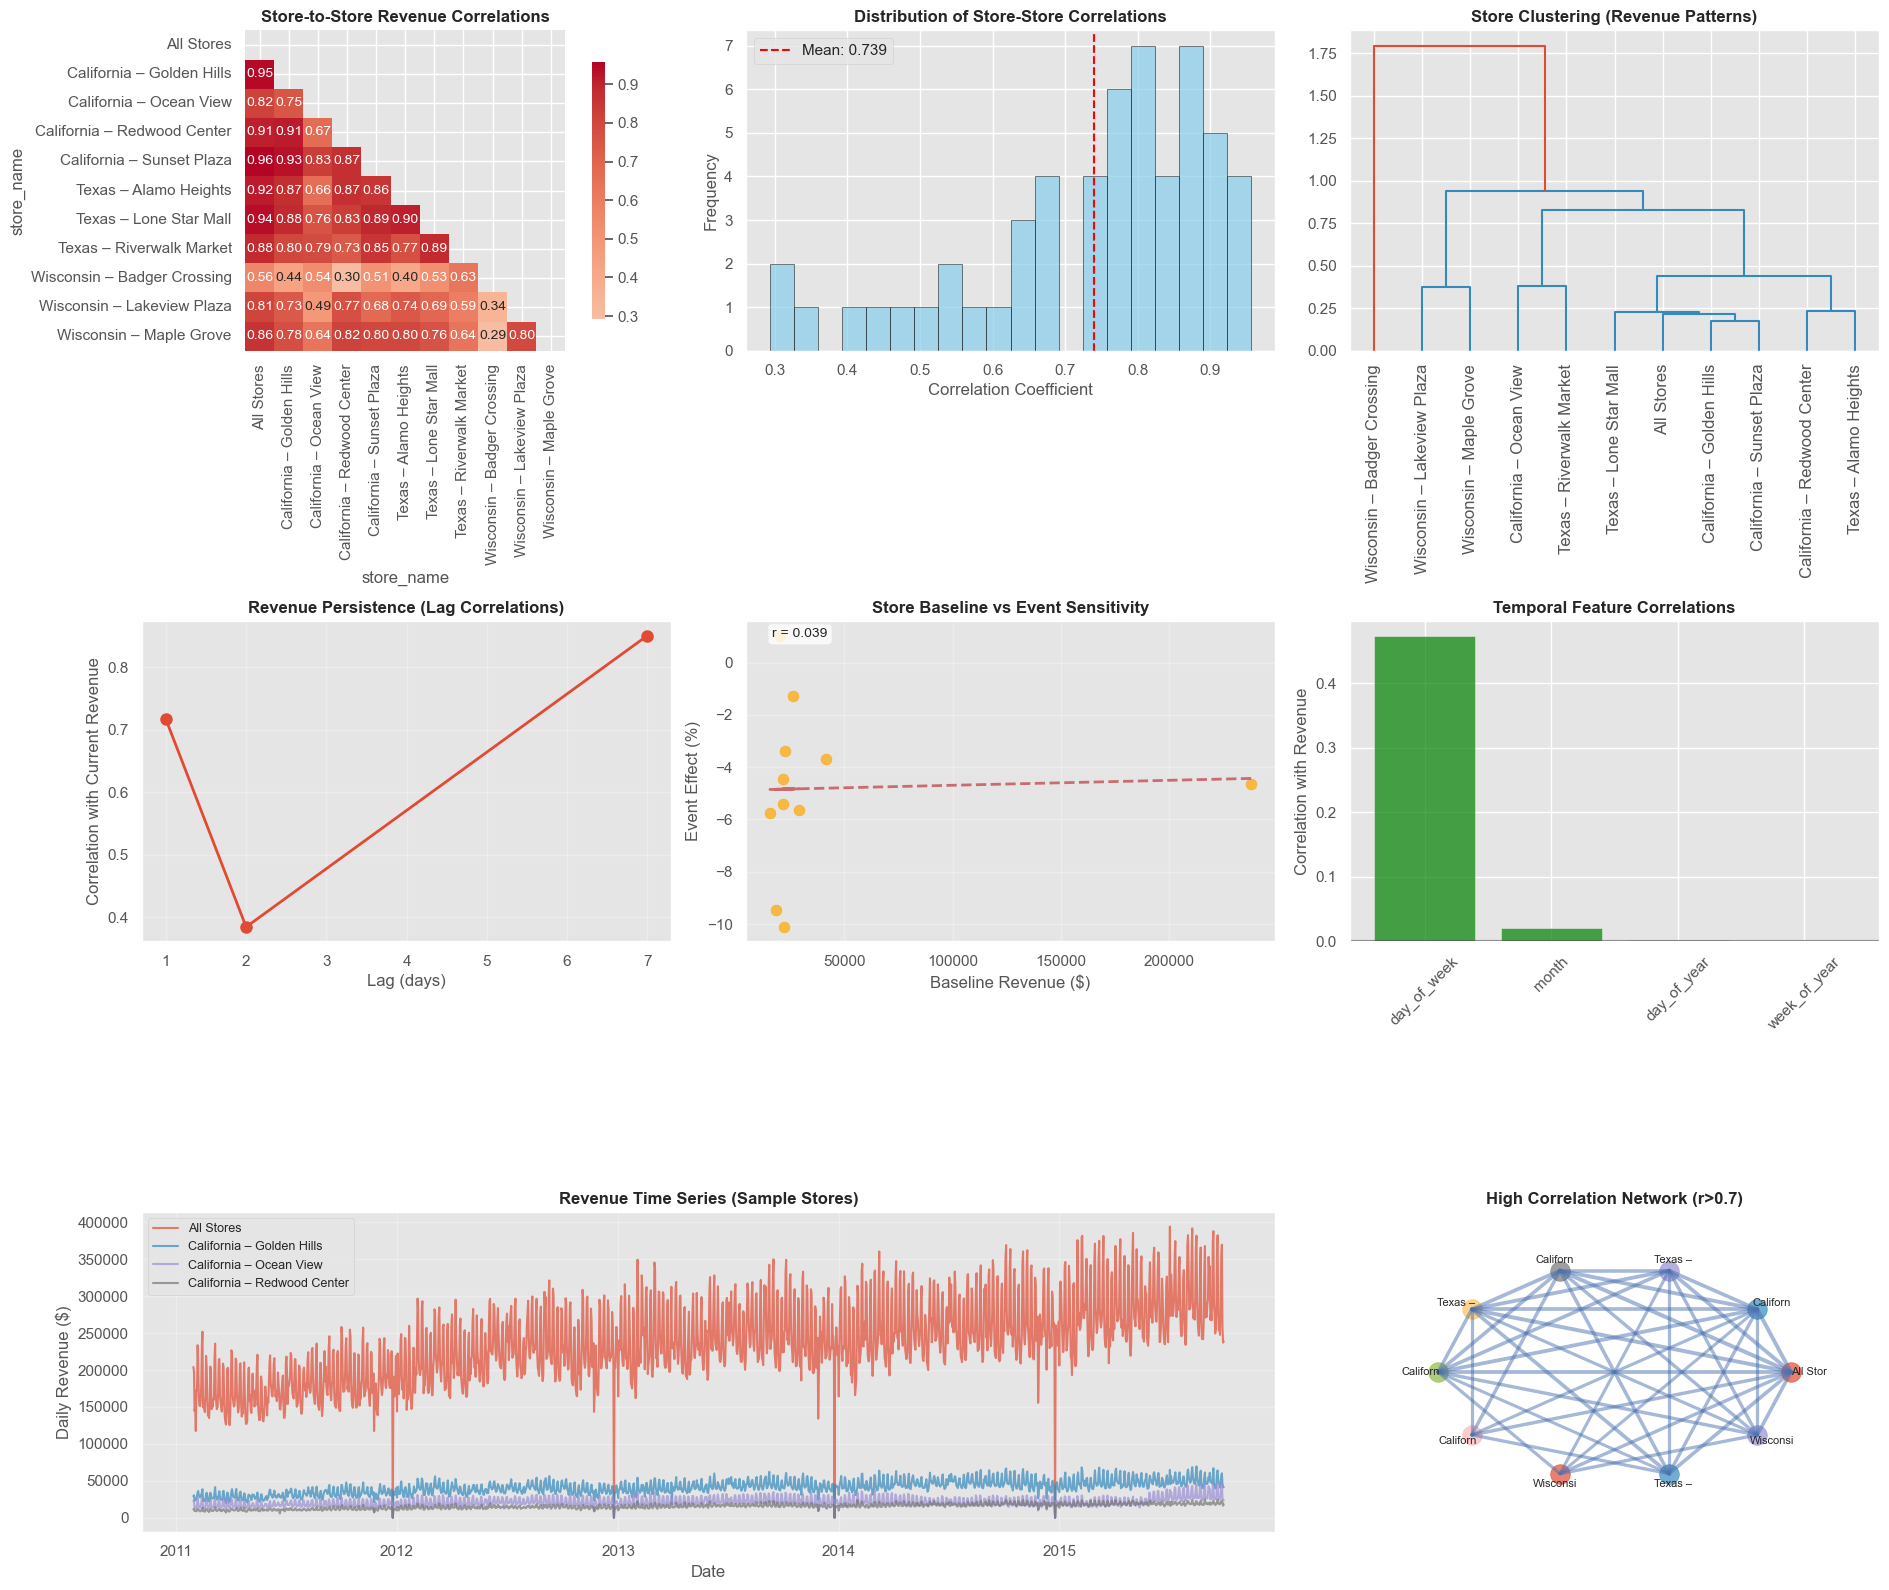



7. KEY INSIGHTS AND RECOMMENDATIONS
--------------------------------------------------
Key Findings:
1. High store synchronization (avg r=0.739) - centralized factors dominate
2. Strong day-to-day revenue persistence - trends continue
3. Weekly patterns detected - consider weekly planning cycles
4. Strongest store influence: California – Sunset Plaza → All Stores (7 day lag)

Strategic Recommendations:
• Focus on centralized marketing and operations (high synchronization)
• Shared promotional campaigns will be effective across stores
• Use lead-lag relationships for predictive planning
• Monitor highly correlated stores for consistent performance
• Investigate why some stores have low correlations with others


In [61]:
def comprehensive_correlation_analysis(df, event_col='event', min_days_threshold=30):
    """
    Comprehensive correlation analysis including store-to-store and other relationships
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: store_name, date, revenue, event_col
    event_col : str
        Name of the event/calendar column
    min_days_threshold : int
        Minimum number of days required for store inclusion
    """
    
    # Prepare the data
    df_analysis = df.copy()
    df_analysis['date'] = pd.to_datetime(df_analysis['date'])
    
    # Extract time features
    df_analysis['year'] = df_analysis['date'].dt.year
    df_analysis['month'] = df_analysis['date'].dt.month
    df_analysis['day_of_week'] = df_analysis['date'].dt.dayofweek
    df_analysis['day_of_year'] = df_analysis['date'].dt.dayofyear
    df_analysis['week_of_year'] = df_analysis['date'].dt.isocalendar().week
    df_analysis['is_weekend'] = df_analysis['day_of_week'].isin([5, 6])
    df_analysis['is_month_start'] = df_analysis['date'].dt.is_month_start
    df_analysis['is_month_end'] = df_analysis['date'].dt.is_month_end
    df_analysis['has_event'] = df_analysis[event_col].notna()
    
    # Filter stores with sufficient data
    store_counts = df_analysis.groupby('store_name').size()
    eligible_stores = store_counts[store_counts >= min_days_threshold].index.tolist()
    df_filtered = df_analysis[df_analysis['store_name'].isin(eligible_stores)]
    
    print("COMPREHENSIVE CORRELATION ANALYSIS")
    print("=" * 60)
    print(f"Analyzing {len(eligible_stores)} stores with ≥{min_days_threshold} days of data")
    print(f"Date range: {df_filtered['date'].min().strftime('%Y-%m-%d')} to {df_filtered['date'].max().strftime('%Y-%m-%d')}")
    
    # =====================================
    # 1. STORE-TO-STORE CORRELATIONS
    # =====================================
    print("\n1. STORE-TO-STORE REVENUE CORRELATIONS")
    print("-" * 50)
    
    # Create store revenue pivot table (daily revenue by store)
    store_revenue_pivot = df_filtered.pivot_table(
        index='date', 
        columns='store_name', 
        values='revenue', 
        aggfunc='sum'
    ).fillna(0)
    
    # Calculate store-to-store correlation matrix
    store_corr_matrix = store_revenue_pivot.corr()
    
    # Remove self-correlations and get upper triangle
    mask = np.triu(np.ones_like(store_corr_matrix, dtype=bool))
    store_corr_values = store_corr_matrix.where(~mask)
    
    # Store correlation statistics
    non_self_corrs = []
    for i in range(len(store_corr_matrix)):
        for j in range(i+1, len(store_corr_matrix)):
            corr_val = store_corr_matrix.iloc[i, j]
            if not np.isnan(corr_val):
                non_self_corrs.append({
                    'store1': store_corr_matrix.index[i],
                    'store2': store_corr_matrix.columns[j],
                    'correlation': corr_val
                })
    
    corr_df = pd.DataFrame(non_self_corrs).sort_values('correlation', ascending=False)
    
    print(f"Store-to-Store Correlation Summary:")
    print(f"Average correlation: {corr_df['correlation'].mean():.3f}")
    print(f"Median correlation: {corr_df['correlation'].median():.3f}")
    print(f"Standard deviation: {corr_df['correlation'].std():.3f}")
    print(f"Range: {corr_df['correlation'].min():.3f} to {corr_df['correlation'].max():.3f}")
    
    print(f"\nHighest Correlated Store Pairs:")
    print(f"{'Store 1':<20} {'Store 2':<20} {'Correlation':<12}")
    print("-" * 55)
    for _, row in corr_df.head(10).iterrows():
        print(f"{row['store1']:<20} {row['store2']:<20} {row['correlation']:<12.3f}")
    
    print(f"\nLowest Correlated Store Pairs:")
    for _, row in corr_df.tail(5).iterrows():
        print(f"{row['store1']:<20} {row['store2']:<20} {row['correlation']:<12.3f}")
    
    # =====================================
    # 2. TEMPORAL CORRELATIONS
    # =====================================
    print("\n\n2. TEMPORAL CORRELATIONS")
    print("-" * 40)
    
    # Aggregate daily data across all stores
    daily_agg = df_filtered.groupby('date').agg({
        'revenue': 'sum',
        'day_of_week': 'first',
        'month': 'first',
        'day_of_year': 'first',
        'week_of_year': 'first',
        'is_weekend': 'first',
        'is_month_start': 'first',
        'is_month_end': 'first',
        'has_event': 'any'
    }).reset_index()
    
    # Add lag features
    daily_agg = daily_agg.sort_values('date')
    daily_agg['revenue_lag1'] = daily_agg['revenue'].shift(1)
    daily_agg['revenue_lag2'] = daily_agg['revenue'].shift(2)
    daily_agg['revenue_lag7'] = daily_agg['revenue'].shift(7)  # Week-over-week
    daily_agg['revenue_lead1'] = daily_agg['revenue'].shift(-1)
    
    # Calculate rolling averages
    daily_agg['revenue_ma7'] = daily_agg['revenue'].rolling(window=7, center=True).mean()
    daily_agg['revenue_ma14'] = daily_agg['revenue'].rolling(window=14, center=True).mean()
    
    # Temporal correlation analysis
    temporal_features = ['day_of_week', 'month', 'day_of_year', 'week_of_year']
    temporal_corrs = {}
    
    for feature in temporal_features:
        corr, p_value = pearsonr(daily_agg[feature].dropna(), daily_agg['revenue'].dropna())
        temporal_corrs[feature] = {'correlation': corr, 'p_value': p_value}
    
    # Lag correlations
    lag_features = ['revenue_lag1', 'revenue_lag2', 'revenue_lag7']
    lag_corrs = {}
    
    for lag_feature in lag_features:
        valid_data = daily_agg[[lag_feature, 'revenue']].dropna()
        if len(valid_data) > 1:
            corr, p_value = pearsonr(valid_data[lag_feature], valid_data['revenue'])
            lag_corrs[lag_feature] = {'correlation': corr, 'p_value': p_value}
    
    print("Temporal Correlations with Revenue:")
    print(f"{'Feature':<15} {'Correlation':<12} {'P-value':<10} {'Significance':<12}")
    print("-" * 55)
    
    for feature, stats in temporal_corrs.items():
        significance = "***" if stats['p_value'] < 0.001 else "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
        print(f"{feature:<15} {stats['correlation']:<12.3f} {stats['p_value']:<10.3f} {significance:<12}")
    
    print(f"\nLag Correlations (Revenue Persistence):")
    for lag_feature, stats in lag_corrs.items():
        lag_days = lag_feature.split('_lag')[1]
        significance = "***" if stats['p_value'] < 0.001 else "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
        print(f"{lag_days} day lag: {stats['correlation']:<12.3f} {stats['p_value']:<10.3f} {significance:<12}")
    
    # =====================================
    # 3. EVENT CORRELATIONS
    # =====================================
    print("\n\n3. EVENT CORRELATIONS")
    print("-" * 40)
    
    # Event impact correlations
    event_revenue_corr = daily_agg[['has_event', 'revenue']].corr().iloc[0, 1]
    
    # Calculate event effects by store
    store_event_effects = {}
    for store in eligible_stores:
        store_data = df_filtered[df_filtered['store_name'] == store]
        
        event_revenue = store_data[store_data['has_event']]['revenue'].mean()
        no_event_revenue = store_data[~store_data['has_event']]['revenue'].mean()
        
        if no_event_revenue > 0:
            effect = (event_revenue - no_event_revenue) / no_event_revenue * 100
            store_event_effects[store] = effect
    
    # Correlation between store baseline performance and event sensitivity
    store_baselines = {}
    for store in eligible_stores:
        store_data = df_filtered[df_filtered['store_name'] == store]
        store_baselines[store] = store_data[~store_data['has_event']]['revenue'].mean()
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'baseline_revenue': store_baselines,
        'event_effect': store_event_effects
    }).dropna()
    
    if len(comparison_df) > 2:
        baseline_event_corr, baseline_event_p = pearsonr(
            comparison_df['baseline_revenue'], 
            comparison_df['event_effect']
        )
        
        print(f"Overall Event-Revenue Correlation: {event_revenue_corr:.3f}")
        print(f"Store Baseline vs Event Sensitivity: {baseline_event_corr:.3f} (p={baseline_event_p:.3f})")
    
    # =====================================
    # 4. CROSS-STORE INFLUENCE ANALYSIS
    # =====================================
    print("\n\n4. CROSS-STORE INFLUENCE ANALYSIS")
    print("-" * 40)
    
    # Calculate lead-lag correlations between stores
    lead_lag_results = {}
    
    for i, store1 in enumerate(eligible_stores[:5]):  # Limit to top 5 stores for performance
        for store2 in eligible_stores[:5]:
            if store1 != store2:
                store1_revenue = store_revenue_pivot[store1].dropna()
                store2_revenue = store_revenue_pivot[store2].dropna()
                
                # Align dates
                common_dates = store1_revenue.index.intersection(store2_revenue.index)
                if len(common_dates) > 30:  # Need sufficient data
                    s1_aligned = store1_revenue[common_dates]
                    s2_aligned = store2_revenue[common_dates]
                    
                    # Test different lags
                    max_lag = min(7, len(common_dates) // 4)  # Up to 7 days or 25% of data
                    
                    for lag in range(1, max_lag + 1):
                        if len(s1_aligned) > lag:
                            # Store1 leads Store2
                            lead_corr, _ = pearsonr(s1_aligned[:-lag], s2_aligned[lag:])
                            
                            key = f"{store1}_leads_{store2}_{lag}d"
                            lead_lag_results[key] = {
                                'leader': store1,
                                'follower': store2,
                                'lag_days': lag,
                                'correlation': lead_corr
                            }
    
    # Find strongest lead-lag relationships
    if lead_lag_results:
        lead_lag_df = pd.DataFrame(lead_lag_results).T
        lead_lag_df = lead_lag_df.sort_values('correlation', ascending=False)
        
        print("Strongest Lead-Lag Relationships (Store Influence):")
        print(f"{'Leader Store':<15} {'Follower Store':<15} {'Lag (days)':<10} {'Correlation':<12}")
        print("-" * 60)
        
        for _, row in lead_lag_df.head(10).iterrows():
            print(f"{row['leader']:<15} {row['follower']:<15} {row['lag_days']:<10} {row['correlation']:<12.3f}")
    
    # =====================================
    # 5. EXTERNAL FACTOR CORRELATIONS
    # =====================================
    print("\n\n5. EXTERNAL FACTOR CORRELATIONS")
    print("-" * 40)
    
    # Weekend effect correlation
    weekend_corr = daily_agg[['is_weekend', 'revenue']].corr().iloc[0, 1]
    
    # Month-end/start effects
    month_start_corr = daily_agg[['is_month_start', 'revenue']].corr().iloc[0, 1]
    month_end_corr = daily_agg[['is_month_end', 'revenue']].corr().iloc[0, 1]
    
    print(f"Weekend Effect Correlation: {weekend_corr:.3f}")
    print(f"Month Start Effect: {month_start_corr:.3f}")
    print(f"Month End Effect: {month_end_corr:.3f}")
    
    # =====================================
    # 6. VISUALIZATIONS
    # =====================================
    
    # Create comprehensive correlation visualizations
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Store-to-Store Correlation Heatmap
    ax1 = plt.subplot(3, 3, 1)
    mask = np.triu(np.ones_like(store_corr_matrix, dtype=bool))
    sns.heatmap(store_corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=ax1)
    ax1.set_title('Store-to-Store Revenue Correlations', fontsize=12, fontweight='bold')
    
    # 2. Correlation Distribution
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(corr_df['correlation'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(corr_df['correlation'].mean(), color='red', linestyle='--', 
               label=f'Mean: {corr_df["correlation"].mean():.3f}')
    ax2.set_title('Distribution of Store-Store Correlations', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Correlation Coefficient')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Store Clustering Dendrogram
    ax3 = plt.subplot(3, 3, 3)
    if len(store_corr_matrix) > 2:
        # Convert correlation to distance
        distance_matrix = 1 - store_corr_matrix
        linkage_matrix = linkage(distance_matrix, method='ward')
        
        dendrogram(linkage_matrix, labels=store_corr_matrix.index, ax=ax3, 
                  orientation='top', leaf_rotation=90)
        ax3.set_title('Store Clustering (Revenue Patterns)', fontsize=12, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'Insufficient stores\nfor clustering', 
                ha='center', va='center', transform=ax3.transAxes)
    
    # 4. Revenue vs Lag Correlations
    ax4 = plt.subplot(3, 3, 4)
    if lag_corrs:
        lag_days = [int(k.split('_lag')[1]) for k in lag_corrs.keys()]
        lag_values = [v['correlation'] for v in lag_corrs.values()]
        
        ax4.plot(lag_days, lag_values, 'o-', linewidth=2, markersize=8)
        ax4.set_title('Revenue Persistence (Lag Correlations)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Lag (days)')
        ax4.set_ylabel('Correlation with Current Revenue')
        ax4.grid(True, alpha=0.3)
    
    # 5. Store Baseline vs Event Sensitivity
    ax5 = plt.subplot(3, 3, 5)
    if len(comparison_df) > 2:
        scatter = ax5.scatter(comparison_df['baseline_revenue'], comparison_df['event_effect'], 
                             alpha=0.7, s=60, c='orange')
        
        # Add trend line
        z = np.polyfit(comparison_df['baseline_revenue'], comparison_df['event_effect'], 1)
        p = np.poly1d(z)
        ax5.plot(comparison_df['baseline_revenue'], p(comparison_df['baseline_revenue']), 
                "r--", alpha=0.8, linewidth=2)
        
        ax5.set_title('Store Baseline vs Event Sensitivity', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Baseline Revenue ($)')
        ax5.set_ylabel('Event Effect (%)')
        ax5.grid(True, alpha=0.3)
        
        # Add correlation text
        ax5.text(0.05, 0.95, f'r = {baseline_event_corr:.3f}', 
                transform=ax5.transAxes, fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 6. Temporal Correlations
    ax6 = plt.subplot(3, 3, 6)
    temp_features = list(temporal_corrs.keys())
    temp_values = [temporal_corrs[k]['correlation'] for k in temp_features]
    
    colors = ['green' if v > 0 else 'red' for v in temp_values]
    bars = ax6.bar(temp_features, temp_values, color=colors, alpha=0.7)
    ax6.set_title('Temporal Feature Correlations', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Correlation with Revenue')
    ax6.tick_params(axis='x', rotation=45)
    ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 7. Daily Revenue Time Series (sample stores)
    ax7 = plt.subplot(3, 3, (7, 8))
    sample_stores = eligible_stores[:4]  # Show top 4 stores
    
    for store in sample_stores:
        store_ts = store_revenue_pivot[store].dropna()
        ax7.plot(store_ts.index, store_ts.values, label=store, alpha=0.7, linewidth=1.5)
    
    ax7.set_title('Revenue Time Series (Sample Stores)', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Date')
    ax7.set_ylabel('Daily Revenue ($)')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # 8. Correlation Network (if many stores)
    ax8 = plt.subplot(3, 3, 9)
    if len(eligible_stores) >= 3:
        # Create a simple correlation network visualization
        high_corr_pairs = corr_df[corr_df['correlation'] > 0.7]  # Strong correlations only
        
        if len(high_corr_pairs) > 0:
            # Simple network plot
            stores_in_network = pd.concat([high_corr_pairs['store1'], high_corr_pairs['store2']]).unique()
            
            # Create positions for stores
            angles = np.linspace(0, 2*np.pi, len(stores_in_network), endpoint=False)
            positions = {store: (np.cos(angle), np.sin(angle)) for store, angle in zip(stores_in_network, angles)}
            
            # Plot stores
            for store, (x, y) in positions.items():
                ax8.scatter(x, y, s=200, alpha=0.7)
                ax8.text(x*1.1, y*1.1, store[:8], ha='center', va='center', fontsize=8)
            
            # Plot connections
            for _, row in high_corr_pairs.iterrows():
                if row['store1'] in positions and row['store2'] in positions:
                    x1, y1 = positions[row['store1']]
                    x2, y2 = positions[row['store2']]
                    ax8.plot([x1, x2], [y1, y2], 'b-', alpha=0.5, 
                            linewidth=row['correlation']*3)
            
            ax8.set_title('High Correlation Network (r>0.7)', fontsize=12, fontweight='bold')
        else:
            ax8.text(0.5, 0.5, 'No strong correlations\n(r > 0.7) found', 
                    ha='center', va='center', transform=ax8.transAxes)
        
        ax8.set_xlim(-1.5, 1.5)
        ax8.set_ylim(-1.5, 1.5)
        ax8.axis('off')
    else:
        ax8.text(0.5, 0.5, 'Insufficient stores\nfor network analysis', 
                ha='center', va='center', transform=ax8.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # =====================================
    # 7. KEY INSIGHTS AND RECOMMENDATIONS
    # =====================================
    print("\n\n7. KEY INSIGHTS AND RECOMMENDATIONS")
    print("-" * 50)
    
    insights = []
    
    # Store correlation insights
    avg_store_corr = corr_df['correlation'].mean()
    if avg_store_corr > 0.7:
        insights.append(f"High store synchronization (avg r={avg_store_corr:.3f}) - centralized factors dominate")
    elif avg_store_corr < 0.3:
        insights.append(f"Low store synchronization (avg r={avg_store_corr:.3f}) - local factors dominate")
    else:
        insights.append(f"Moderate store synchronization (avg r={avg_store_corr:.3f}) - mixed influences")
    
    # Temporal insights
    if 'revenue_lag1' in lag_corrs and lag_corrs['revenue_lag1']['correlation'] > 0.5:
        insights.append("Strong day-to-day revenue persistence - trends continue")
    
    if 'revenue_lag7' in lag_corrs and lag_corrs['revenue_lag7']['correlation'] > 0.3:
        insights.append("Weekly patterns detected - consider weekly planning cycles")
    
    # Event insights
    if event_revenue_corr > 0.1:
        insights.append(f"Events positively correlate with revenue (r={event_revenue_corr:.3f})")
    elif event_revenue_corr < -0.1:
        insights.append(f"Events negatively correlate with revenue (r={event_revenue_corr:.3f})")
    
    # Lead-lag insights
    if lead_lag_results:
        strongest_influence = lead_lag_df.iloc[0]
        insights.append(f"Strongest store influence: {strongest_influence['leader']} → {strongest_influence['follower']} ({strongest_influence['lag_days']} day lag)")
    
    print("Key Findings:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    print("\nStrategic Recommendations:")
    if avg_store_corr > 0.7:
        print("• Focus on centralized marketing and operations (high synchronization)")
        print("• Shared promotional campaigns will be effective across stores")
    else:
        print("• Customize strategies by individual store (low synchronization)")
        print("• Local market factors are more important than chain-wide trends")
    
    print("• Use lead-lag relationships for predictive planning")
    print("• Monitor highly correlated stores for consistent performance")
    print("• Investigate why some stores have low correlations with others")
    
    return {
        'store_correlations': store_corr_matrix,
        'correlation_summary': corr_df,
        'temporal_correlations': temporal_corrs,
        'lag_correlations': lag_corrs,
        'lead_lag_relationships': lead_lag_df if 'lead_lag_df' in locals() else pd.DataFrame(),
        'event_correlations': {
            'overall_event_correlation': event_revenue_corr,
            'baseline_event_sensitivity': baseline_event_corr if 'baseline_event_corr' in locals() else None
        },
        'store_revenue_data': store_revenue_pivot
    }

# Usage:
results = comprehensive_correlation_analysis(train, event_col='event')

ADVANCED CORRELATION AND FEATURE ANALYSIS
Analyzing 11 stores with ≥60 days of data
Maximum lag analysis: 30 days
Date range: 2011-01-29 to 2015-09-30

1. AUTOCORRELATION ANALYSIS (PER STORE)
--------------------------------------------------
Autocorrelation Summary (Average across all stores):
Lag      Avg Correlation  Strong Stores (>0.5) Weak Stores (<0.2)  
----------------------------------------------------------------------
1        0.693            11                   0                   
2        0.398            4                    2                   
3        0.255            2                    5                   
7        0.806            11                   0                   
14       0.752            10                   0                   
21       0.772            10                   0                   
30       0.400            4                    2                   

Best Lag Features by Store (Top 5):
Store                Best Lag   Correlation  Recomme

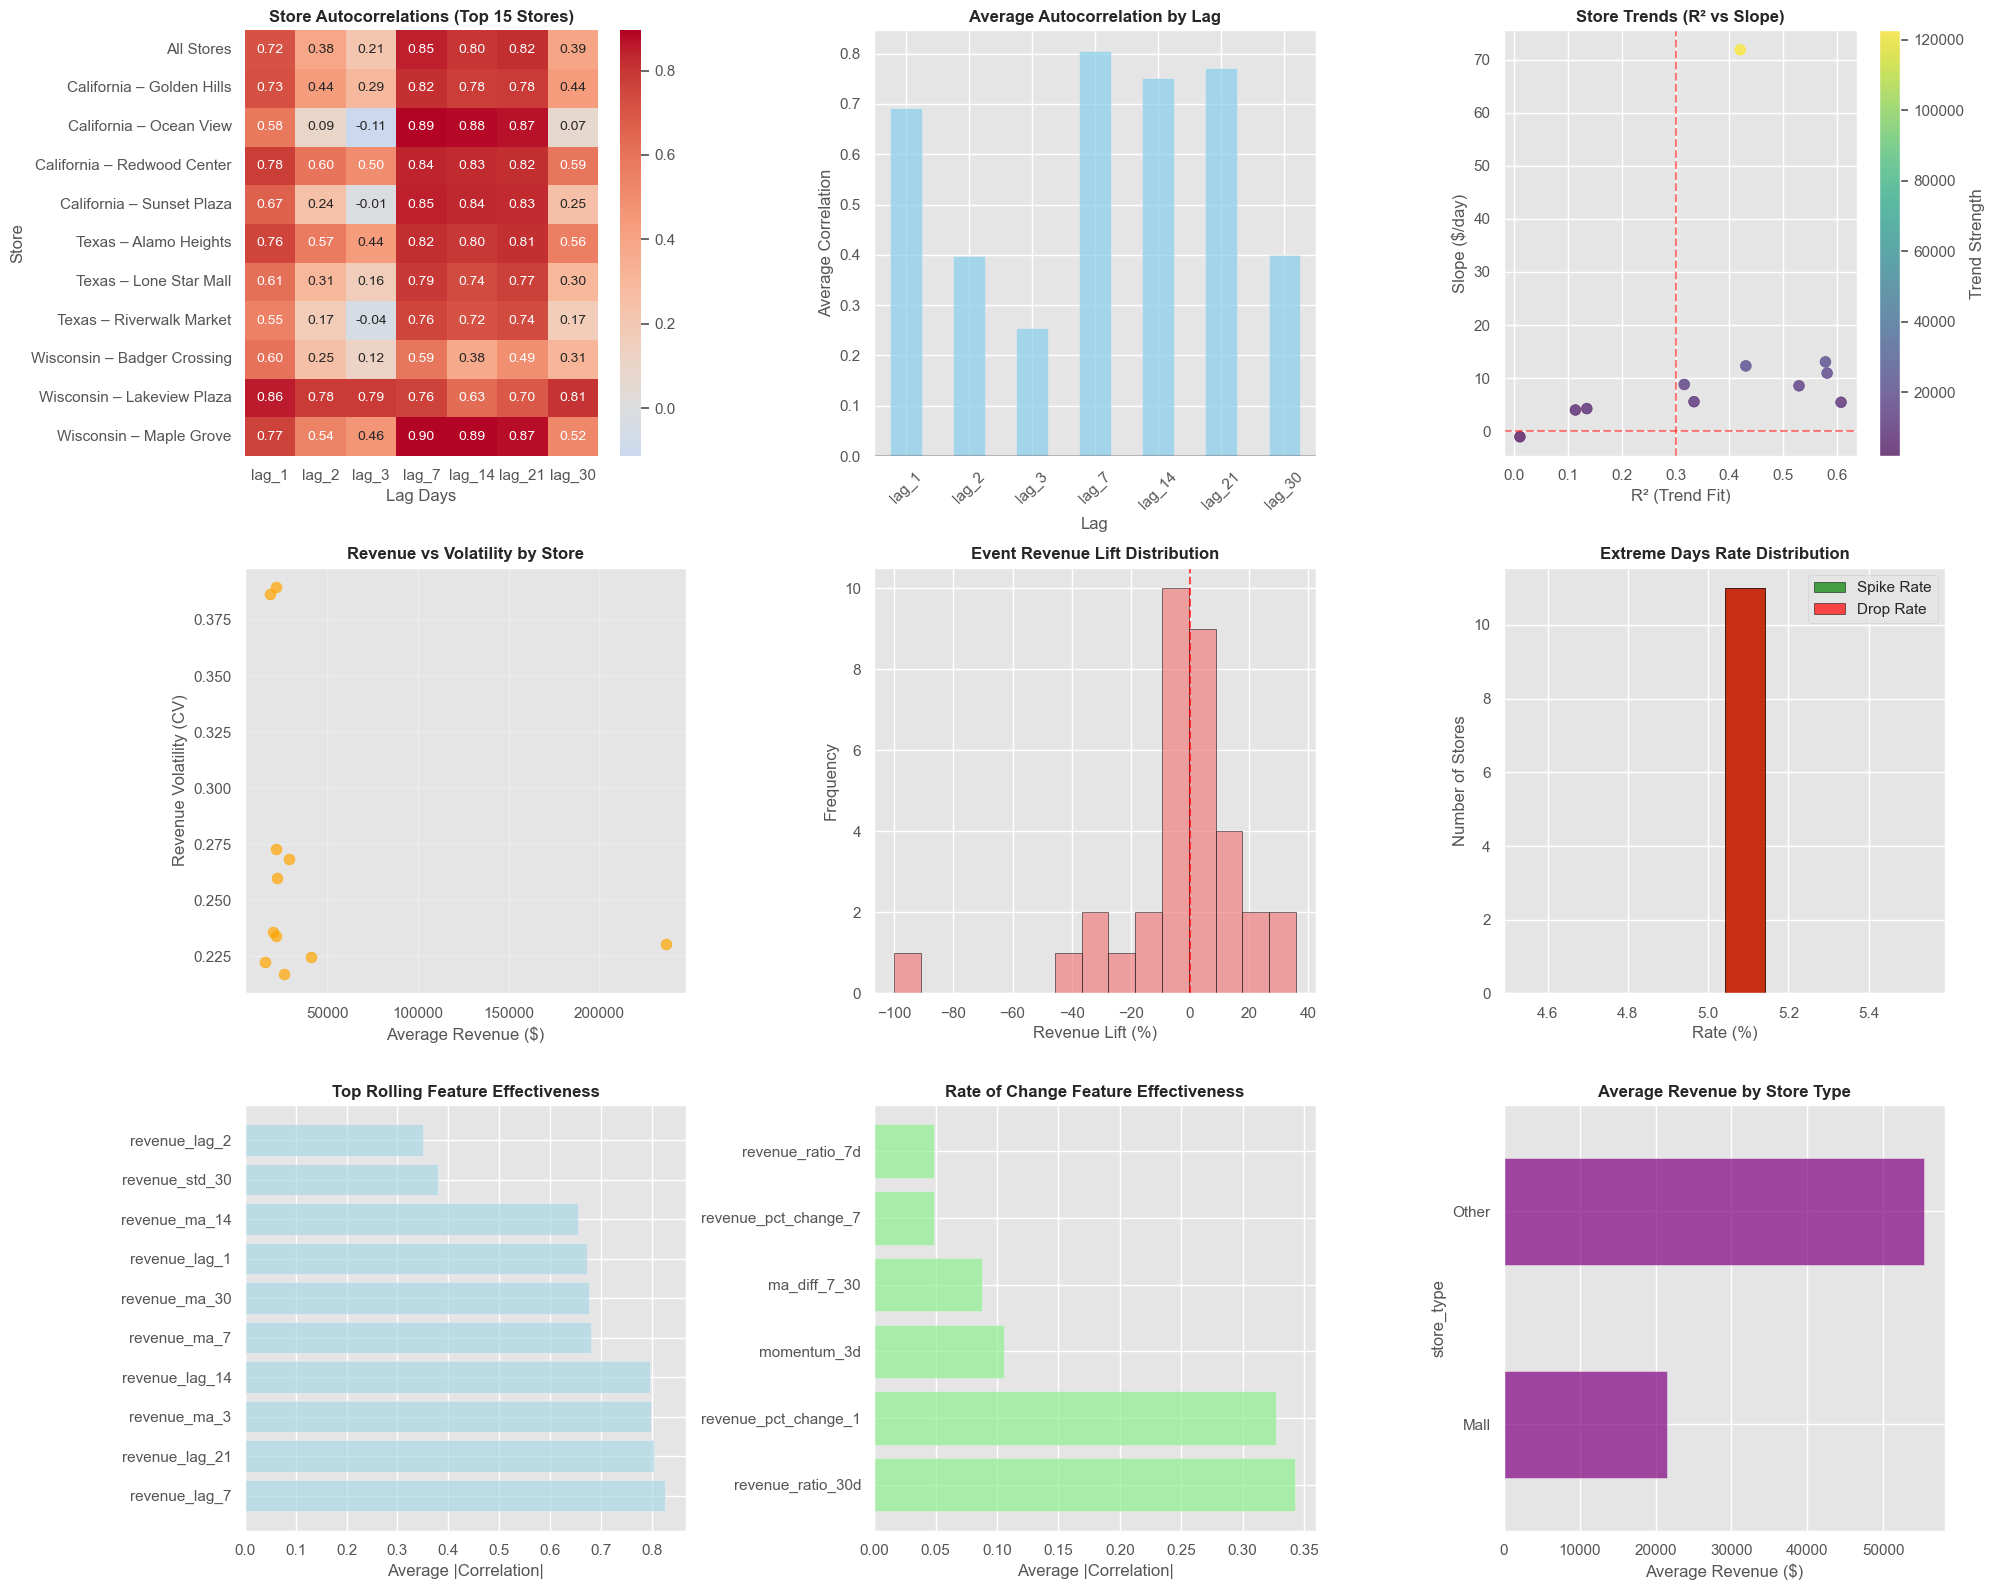



9. FEATURE ENGINEERING RECOMMENDATIONS
--------------------------------------------------
 MUST-HAVE FEATURES:
• Lag Features: 7 days, 21 days, 14 days
• Rolling Features: revenue_lag_7, revenue_lag_21, revenue_ma_3
• Rate of Change: revenue_ratio_30d, revenue_pct_change_1d
• Trend Features: 'days_since_start' for 8 stores with strong trends

 STORE-SPECIFIC FEATURES:
• Store Performance Tier: Based on avg_revenue percentiles
• Store Volatility Category: Based on revenue_volatility quartiles
• Store Event Sensitivity: Based on event_sensitivity scores

 CALENDAR/EVENT FEATURES:
• High-Impact Event Dummies: 14 events with >10% revenue impact
• Event Lead/Lag Windows: 'days_until_event', 'days_after_event'
• One-Hot Encoding: 34 frequently occurring events

⚙️ FEATURE ENGINEERING PIPELINE:
1. Create lag features: 7, 21, 14 days
2. Calculate rolling statistics: MA, STD for windows 7, 14, 30
3. Generate rate-of-change features: pct_change, ratios, momentum
4. Add store metadata: performa

In [62]:
def advanced_correlation_feature_analysis(df, event_col='event', max_lag=30, min_days_threshold=60):
    """
    Comprehensive lag, rolling, and autocorrelation analysis for feature engineering
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: store_name, date, revenue, event_col
    event_col : str
        Name of the event/calendar column
    max_lag : int
        Maximum lag days to analyze
    min_days_threshold : int
        Minimum number of days required for store inclusion
    """
    
    # Prepare the data
    df_analysis = df.copy()
    df_analysis['date'] = pd.to_datetime(df_analysis['date'])
    df_analysis = df_analysis.sort_values(['store_name', 'date'])
    
    # Filter stores with sufficient data
    store_counts = df_analysis.groupby('store_name').size()
    eligible_stores = store_counts[store_counts >= min_days_threshold].index.tolist()
    df_filtered = df_analysis[df_analysis['store_name'].isin(eligible_stores)]
    
    print("ADVANCED CORRELATION AND FEATURE ANALYSIS")
    print("=" * 70)
    print(f"Analyzing {len(eligible_stores)} stores with ≥{min_days_threshold} days of data")
    print(f"Maximum lag analysis: {max_lag} days")
    print(f"Date range: {df_filtered['date'].min().strftime('%Y-%m-%d')} to {df_filtered['date'].max().strftime('%Y-%m-%d')}")
    
    # =====================================
    # 1. AUTOCORRELATION ANALYSIS (PER STORE)
    # =====================================
    print("\n1. AUTOCORRELATION ANALYSIS (PER STORE)")
    print("-" * 50)
    
    # Calculate autocorrelations for each store
    autocorr_results = {}
    lag_range = [1, 2, 3, 7, 14, 21, 30] if max_lag >= 30 else list(range(1, max_lag + 1))
    
    for store in eligible_stores:
        store_data = df_filtered[df_filtered['store_name'] == store].copy()
        store_data = store_data.sort_values('date')
        
        store_autocorr = {}
        for lag in lag_range:
            if len(store_data) > lag:
                # Create lagged revenue
                revenue_current = store_data['revenue'].iloc[lag:]
                revenue_lagged = store_data['revenue'].iloc[:-lag]
                
                if len(revenue_current) > 1 and len(revenue_lagged) > 1:
                    corr, p_value = pearsonr(revenue_current, revenue_lagged)
                    store_autocorr[f'lag_{lag}'] = {'correlation': corr, 'p_value': p_value}
        
        autocorr_results[store] = store_autocorr
    
    # Create autocorrelation DataFrame
    autocorr_df = pd.DataFrame({
        store: {lag: data['correlation'] for lag, data in autocorrs.items()}
        for store, autocorrs in autocorr_results.items()
    }).T
    
    print("Autocorrelation Summary (Average across all stores):")
    autocorr_avg = autocorr_df.mean()
    print(f"{'Lag':<8} {'Avg Correlation':<16} {'Strong Stores (>0.5)':<20} {'Weak Stores (<0.2)':<20}")
    print("-" * 70)
    
    for lag, avg_corr in autocorr_avg.items():
        lag_num = lag.split('_')[1]
        strong_count = (autocorr_df[lag] > 0.5).sum()
        weak_count = (autocorr_df[lag] < 0.2).sum()
        print(f"{lag_num:<8} {avg_corr:<16.3f} {strong_count:<20} {weak_count:<20}")
    
    # Identify best lags per store
    print(f"\nBest Lag Features by Store (Top 5):")
    print(f"{'Store':<20} {'Best Lag':<10} {'Correlation':<12} {'Recommended Lags':<25}")
    print("-" * 75)
    
    for store in autocorr_df.index[:10]:  # Top 10 stores
        store_corrs = autocorr_df.loc[store].dropna()
        if len(store_corrs) > 0:
            best_lag = store_corrs.idxmax()
            best_corr = store_corrs.max()
            
            # Get top 3 lags for this store
            top_lags = store_corrs.nlargest(3).index.tolist()
            recommended = ', '.join([lag.split('_')[1] for lag in top_lags])
            
            print(f"{store[:19]:<20} {best_lag.split('_')[1]:<10} {best_corr:<12.3f} {recommended:<25}")
    
    # =====================================
    # 2. LAG AND ROLLING FEATURE CORRELATION ANALYSIS
    # =====================================
    print("\n\n2. LAG AND ROLLING FEATURE CORRELATION ANALYSIS")
    print("-" * 50)
    
    # Create comprehensive lag and rolling features for validation
    rolling_correlations = {}
    
    for store in eligible_stores[:8]:  # Limit for performance
        store_data = df_filtered[df_filtered['store_name'] == store].copy()
        store_data = store_data.sort_values('date').reset_index(drop=True)
        
        # Create lag features
        for lag in [1, 2, 3, 7, 14, 21, 30]:
            if lag < len(store_data):
                store_data[f'revenue_lag_{lag}'] = store_data['revenue'].shift(lag)
        
        # Create rolling features
        for window in [3, 7, 14, 30]:
            if window < len(store_data):
                store_data[f'revenue_ma_{window}'] = store_data['revenue'].rolling(window=window).mean()
                store_data[f'revenue_std_{window}'] = store_data['revenue'].rolling(window=window).std()
        
        # Calculate correlations with current revenue
        feature_cols = [col for col in store_data.columns if 'revenue_' in col and col != 'revenue']
        store_rolling_corr = {}
        
        for feature in feature_cols:
            valid_data = store_data[['revenue', feature]].dropna()
            if len(valid_data) > 10:
                corr, p_value = pearsonr(valid_data['revenue'], valid_data[feature])
                store_rolling_corr[feature] = {'correlation': corr, 'p_value': p_value}
        
        rolling_correlations[store] = store_rolling_corr
    
    # Summarize rolling feature effectiveness
    print("Rolling Feature Effectiveness (Average correlations):")
    all_features = set()
    for store_features in rolling_correlations.values():
        all_features.update(store_features.keys())
    
    feature_avg_corr = {}
    for feature in all_features:
        corrs = []
        for store_features in rolling_correlations.values():
            if feature in store_features:
                corrs.append(abs(store_features[feature]['correlation']))  # Use absolute value
        if corrs:
            feature_avg_corr[feature] = np.mean(corrs)
    
    # Sort by effectiveness
    sorted_features = sorted(feature_avg_corr.items(), key=lambda x: x[1], reverse=True)
    
    print(f"{'Feature':<20} {'Avg |Correlation|':<18} {'Recommendation':<15}")
    print("-" * 60)
    
    for feature, avg_corr in sorted_features[:15]:
        if avg_corr > 0.5:
            recommendation = "Strong"
        elif avg_corr > 0.3:
            recommendation = "Moderate"
        elif avg_corr > 0.1:
            recommendation = "Weak"
        else:
            recommendation = "Skip"
        
        print(f"{feature:<20} {avg_corr:<18.3f} {recommendation:<15}")
    
    # =====================================
    # 3. TREND EXTRACTION / DETRENDING
    # =====================================
    print("\n\n3. TREND EXTRACTION / DETRENDING")
    print("-" * 40)
    
    # Calculate trend for each store
    store_trends = {}
    
    for store in eligible_stores:
        store_data = df_filtered[df_filtered['store_name'] == store].copy()
        store_data = store_data.sort_values('date')
        
        # Create time index (days since start)
        store_data['days_since_start'] = (store_data['date'] - store_data['date'].min()).dt.days
        
        # Fit linear trend
        if len(store_data) > 10:
            X = store_data['days_since_start'].values.reshape(-1, 1)
            y = store_data['revenue'].values
            
            model = LinearRegression()
            model.fit(X, y)
            
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(X, y)
            
            # Calculate trend statistics
            trend_strength = abs(slope) * len(store_data)  # Total change over period
            trend_direction = "Increasing" if slope > 0 else "Decreasing"
            
            store_trends[store] = {
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_squared,
                'trend_strength': trend_strength,
                'trend_direction': trend_direction,
                'days_analyzed': len(store_data)
            }
    
    # Sort stores by trend strength
    trends_df = pd.DataFrame(store_trends).T
    trends_df = trends_df.sort_values('trend_strength', ascending=False)
    
    print("Store Trend Analysis:")
    print(f"{'Store':<20} {'Slope ($/day)':<12} {'R²':<8} {'Direction':<12} {'Strength':<12}")
    print("-" * 70)
    
    for store, trend in trends_df.head(10).iterrows():
        print(f"{store[:19]:<20} {trend['slope']:<12.2f} {trend['r_squared']:<8.3f} "
              f"{trend['trend_direction']:<12} {trend['trend_strength']:<12.0f}")
    
    # Trend recommendations
    strong_trends = trends_df[trends_df['r_squared'] > 0.3]
    print(f"\nStores with Strong Trends (R² > 0.3): {len(strong_trends)} stores")
    if len(strong_trends) > 0:
        print("→ Recommendation: Add 'days_since_start' feature for these stores")
    
    # =====================================
    # 4. STORE-LEVEL METADATA FEATURES
    # =====================================
    print("\n\n4. STORE-LEVEL METADATA FEATURES")
    print("-" * 40)
    
    # Calculate store metadata
    store_metadata = {}
    
    for store in eligible_stores:
        store_data = df_filtered[df_filtered['store_name'] == store]
        
        # Basic statistics
        avg_revenue = store_data['revenue'].mean()
        revenue_volatility = store_data['revenue'].std() / avg_revenue  # CV
        total_days = len(store_data)
        
        # Performance metrics
        high_revenue_threshold = store_data['revenue'].quantile(0.8)
        high_revenue_days = (store_data['revenue'] > high_revenue_threshold).sum()
        high_revenue_rate = high_revenue_days / total_days
        
        # Event responsiveness
        if event_col in store_data.columns:
            event_days = store_data[store_data[event_col].notna()]
            no_event_days = store_data[store_data[event_col].isna()]
            
            if len(event_days) > 0 and len(no_event_days) > 0:
                event_avg = event_days['revenue'].mean()
                baseline_avg = no_event_days['revenue'].mean()
                event_sensitivity = (event_avg - baseline_avg) / baseline_avg * 100
            else:
                event_sensitivity = 0
        else:
            event_sensitivity = 0
        
        # Store type inference (basic)
        store_name_lower = store.lower()
        if any(word in store_name_lower for word in ['mall', 'center', 'plaza']):
            store_type = 'Mall'
        elif any(word in store_name_lower for word in ['downtown', 'city', 'urban']):
            store_type = 'Urban'
        elif any(word in store_name_lower for word in ['suburb', 'residential']):
            store_type = 'Suburban'
        else:
            store_type = 'Other'
        
        store_metadata[store] = {
            'avg_revenue': avg_revenue,
            'revenue_volatility': revenue_volatility,
            'total_days': total_days,
            'high_revenue_rate': high_revenue_rate,
            'event_sensitivity': event_sensitivity,
            'store_type': store_type
        }
    
    metadata_df = pd.DataFrame(store_metadata).T
    
    print("Store Metadata Summary:")
    print(f"{'Store':<20} {'Avg Revenue':<12} {'Volatility':<10} {'High Rev %':<10} {'Event Sens%':<12}")
    print("-" * 70)
    
    for store, meta in metadata_df.head(10).iterrows():
        print(f"{store[:19]:<20} ${meta['avg_revenue']:<11,.0f} {meta['revenue_volatility']:<10.3f} "
              f"{meta['high_revenue_rate']*100:<10.1f} {meta['event_sensitivity']:<12.1f}")
    
    # Store type analysis
    print(f"\nStore Type Distribution:")
    type_dist = metadata_df['store_type'].value_counts()
    for store_type, count in type_dist.items():
        avg_revenue = metadata_df[metadata_df['store_type'] == store_type]['avg_revenue'].mean()
        print(f"{store_type}: {count} stores (Avg Revenue: ${avg_revenue:,.0f})")
    
    # =====================================
    # 5. EVENT-TYPE ENCODING ANALYSIS
    # =====================================
    print("\n\n5. EVENT-TYPE ENCODING ANALYSIS")
    print("-" * 40)
    
    if event_col in df_filtered.columns:
        # Analyze event types
        event_data = df_filtered[df_filtered[event_col].notna()].copy()
        
        if len(event_data) > 0:
            # Event frequency and impact
            event_analysis = event_data.groupby(event_col).agg({
                'revenue': ['count', 'mean', 'std'],
                'store_name': 'nunique'
            }).round(2)
            
            event_analysis.columns = ['frequency', 'avg_revenue', 'std_revenue', 'stores_affected']
            
            # Calculate baseline for comparison
            baseline_revenue = df_filtered[df_filtered[event_col].isna()]['revenue'].mean()
            event_analysis['revenue_lift'] = ((event_analysis['avg_revenue'] - baseline_revenue) / baseline_revenue * 100).round(1)
            
            event_analysis = event_analysis.sort_values('revenue_lift', ascending=False)
            
            print(f"Event Type Analysis (Baseline: ${baseline_revenue:,.0f}):")
            print(f"{'Event':<25} {'Frequency':<10} {'Avg Revenue':<12} {'Lift %':<8} {'Stores':<7}")
            print("-" * 70)
            
            for event, stats in event_analysis.head(15).iterrows():
                print(f"{str(event)[:24]:<25} {stats['frequency']:<10.0f} ${stats['avg_revenue']:<11,.0f} "
                      f"{stats['revenue_lift']:>+6.1f}% {stats['stores_affected']:<7.0f}")
            
            # Event encoding recommendations
            print(f"\nEvent Encoding Recommendations:")
            
            high_impact_events = event_analysis[abs(event_analysis['revenue_lift']) > 10]
            print(f"• High-impact events (>10% lift): {len(high_impact_events)} events")
            print(f"  → Create binary features for each")
            
            frequent_events = event_analysis[event_analysis['frequency'] >= 5]
            print(f"• Frequent events (≥5 occurrences): {len(frequent_events)} events")
            print(f"  → Good candidates for one-hot encoding")
            
            # Event lead/lag suggestions
            print(f"• Consider lead/lag windows:")
            print(f"  → 'days_until_event' (1-7 days before)")
            print(f"  → 'days_after_event' (1-3 days after)")
        else:
            print("No events found in the data")
    else:
        print(f"Event column '{event_col}' not found")
    
    # =====================================
    # 6. EXTREME REVENUE DAYS ANALYSIS
    # =====================================
    print("\n\n6. EXTREME REVENUE DAYS ANALYSIS")
    print("-" * 40)
    
    # Calculate extreme days per store
    extreme_analysis = {}
    
    for store in eligible_stores:
        store_data = df_filtered[df_filtered['store_name'] == store]
        
        # Calculate percentiles
        p95 = store_data['revenue'].quantile(0.95)
        p5 = store_data['revenue'].quantile(0.05)
        median = store_data['revenue'].median()
        
        # Identify extreme days
        spike_days = store_data[store_data['revenue'] > p95]
        drop_days = store_data[store_data['revenue'] < p5]
        
        extreme_analysis[store] = {
            'spike_threshold': p95,
            'drop_threshold': p5,
            'spike_days': len(spike_days),
            'drop_days': len(drop_days),
            'spike_rate': len(spike_days) / len(store_data) * 100,
            'drop_rate': len(drop_days) / len(store_data) * 100,
            'spike_avg': spike_days['revenue'].mean() if len(spike_days) > 0 else 0,
            'drop_avg': drop_days['revenue'].mean() if len(drop_days) > 0 else 0
        }
    
    extreme_df = pd.DataFrame(extreme_analysis).T
    
    print("Extreme Revenue Days Analysis:")
    print(f"{'Store':<20} {'Spike Rate%':<10} {'Drop Rate%':<10} {'Spike Avg':<12} {'Drop Avg':<12}")
    print("-" * 70)
    
    for store, stats in extreme_df.head(10).iterrows():
        print(f"{store[:19]:<20} {stats['spike_rate']:<10.1f} {stats['drop_rate']:<10.1f} "
              f"${stats['spike_avg']:<11,.0f} ${stats['drop_avg']:<11,.0f}")
    
    # Recommendations for extreme day features
    high_volatility_stores = extreme_df[extreme_df['spike_rate'] > 10]
    print(f"\nExtreme Day Feature Recommendations:")
    print(f"• High volatility stores (>10% spike rate): {len(high_volatility_stores)} stores")
    print(f"  → Add 'is_spike_day' binary feature")
    print(f"  → Add 'days_since_last_spike' feature")
    print(f"  → Consider store-specific percentile features")
    
    # =====================================
    # 7. REVENUE RATE OF CHANGE FEATURES
    # =====================================
    print("\n\n7. REVENUE RATE OF CHANGE FEATURES")
    print("-" * 40)
    
    # Calculate rate of change features effectiveness
    roc_correlations = {}
    
    for store in eligible_stores[:8]:  # Limit for performance
        store_data = df_filtered[df_filtered['store_name'] == store].copy()
        store_data = store_data.sort_values('date')
        
        # Create rate of change features with proper handling of edge cases
        store_data['revenue_pct_change_1d'] = store_data['revenue'].pct_change(1)
        store_data['revenue_pct_change_7d'] = store_data['revenue'].pct_change(7)
        
        # Ratio features with safe division
        revenue_lag7 = store_data['revenue'].shift(7)
        revenue_lag30 = store_data['revenue'].shift(30)
        
        # Avoid division by zero and create safe ratios
        store_data['revenue_ratio_7d'] = np.where(
            (revenue_lag7 > 0) & (revenue_lag7.notna()), 
            store_data['revenue'] / revenue_lag7, 
            np.nan
        )
        store_data['revenue_ratio_30d'] = np.where(
            (revenue_lag30 > 0) & (revenue_lag30.notna()), 
            store_data['revenue'] / revenue_lag30, 
            np.nan
        )
        
        # Rolling mean differences
        store_data['ma7'] = store_data['revenue'].rolling(7, min_periods=3).mean()
        store_data['ma30'] = store_data['revenue'].rolling(30, min_periods=10).mean()
        store_data['ma_diff_7_30'] = store_data['ma7'] - store_data['ma30']
        
        # Momentum features with safe division
        ma3 = store_data['revenue'].rolling(3, min_periods=2).mean()
        ma7_momentum = store_data['revenue'].rolling(7, min_periods=3).mean()
        
        store_data['momentum_3d'] = np.where(
            (ma7_momentum > 0) & (ma7_momentum.notna()), 
            ma3 / ma7_momentum, 
            np.nan
        )
        
        # Calculate correlations with next day revenue
        store_data['revenue_next'] = store_data['revenue'].shift(-1)
        
        roc_features = ['revenue_pct_change_1d', 'revenue_pct_change_7d', 'revenue_ratio_7d', 
                       'revenue_ratio_30d', 'ma_diff_7_30', 'momentum_3d']
        
        store_roc_corr = {}
        for feature in roc_features:
            # Clean the data: remove inf, -inf, and NaN values
            valid_data = store_data[['revenue_next', feature]].copy()
            
            # Replace infinite values with NaN
            valid_data[feature] = valid_data[feature].replace([np.inf, -np.inf], np.nan)
            valid_data['revenue_next'] = valid_data['revenue_next'].replace([np.inf, -np.inf], np.nan)
            
            # Drop rows with NaN or infinite values
            valid_data = valid_data.dropna()
            
            # Additional check: ensure no extreme outliers that could cause numerical issues
            if len(valid_data) > 10:
                # Remove extreme outliers (beyond 5 standard deviations)
                feature_std = valid_data[feature].std()
                feature_mean = valid_data[feature].mean()
                
                if feature_std > 0 and not pd.isna(feature_std):
                    outlier_mask = (
                        (valid_data[feature] > feature_mean + 5 * feature_std) |
                        (valid_data[feature] < feature_mean - 5 * feature_std)
                    )
                    valid_data = valid_data[~outlier_mask]
                
                # Final check: ensure we still have enough data and no infinite values
                if (len(valid_data) > 10 and 
                    np.isfinite(valid_data[feature]).all() and 
                    np.isfinite(valid_data['revenue_next']).all() and
                    valid_data[feature].std() > 0):
                    
                    try:
                        corr, p_value = pearsonr(valid_data['revenue_next'], valid_data[feature])
                        if np.isfinite(corr) and np.isfinite(p_value):
                            store_roc_corr[feature] = {'correlation': abs(corr), 'p_value': p_value}
                    except (ValueError, RuntimeWarning):
                        # Skip this feature if correlation calculation fails
                        continue
        
        roc_correlations[store] = store_roc_corr
    
    # Summarize rate of change feature effectiveness
    print("Rate of Change Feature Effectiveness:")
    
    roc_features_all = set()
    for store_features in roc_correlations.values():
        roc_features_all.update(store_features.keys())
    
    roc_avg_corr = {}
    for feature in roc_features_all:
        corrs = []
        for store_features in roc_correlations.values():
            if feature in store_features:
                corrs.append(store_features[feature]['correlation'])
        if corrs:
            roc_avg_corr[feature] = np.mean(corrs)
    
    # Sort by effectiveness
    sorted_roc_features = sorted(roc_avg_corr.items(), key=lambda x: x[1], reverse=True)
    
    print(f"{'Feature':<25} {'Avg |Correlation|':<18} {'Recommendation':<15}")
    print("-" * 65)
    
    for feature, avg_corr in sorted_roc_features:
        if avg_corr > 0.3:
            recommendation = "Strong"
        elif avg_corr > 0.15:
            recommendation = "Moderate"
        elif avg_corr > 0.05:
            recommendation = "Weak"
        else:
            recommendation = "Skip"
        
        print(f"{feature:<25} {avg_corr:<18.3f} {recommendation:<15}")
    
    # =====================================
    # 8. COMPREHENSIVE VISUALIZATIONS
    # =====================================
    
    # Create visualization dashboard
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    
    # 1. Autocorrelation Heatmap
    if not autocorr_df.empty:
        sns.heatmap(autocorr_df.iloc[:15], annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0,0])
        axes[0,0].set_title('Store Autocorrelations (Top 15 Stores)', fontsize=12, fontweight='bold')
        axes[0,0].set_xlabel('Lag Days')
        axes[0,0].set_ylabel('Store')
    
    # 2. Average Autocorrelation by Lag
    autocorr_avg.plot(kind='bar', ax=axes[0,1], color='skyblue', alpha=0.7)
    axes[0,1].set_title('Average Autocorrelation by Lag', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Lag')
    axes[0,1].set_ylabel('Average Correlation')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. Store Trend Scatter
    if not trends_df.empty:
        scatter = axes[0,2].scatter(trends_df['r_squared'], trends_df['slope'], 
                                   alpha=0.7, s=60, c=trends_df['trend_strength'], cmap='viridis')
        axes[0,2].set_title('Store Trends (R² vs Slope)', fontsize=12, fontweight='bold')
        axes[0,2].set_xlabel('R² (Trend Fit)')
        axes[0,2].set_ylabel('Slope ($/day)')
        axes[0,2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[0,2].axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='R²=0.3')
        plt.colorbar(scatter, ax=axes[0,2], label='Trend Strength')
    
    # 4. Store Metadata Comparison
    if not metadata_df.empty:
        axes[1,0].scatter(metadata_df['avg_revenue'], metadata_df['revenue_volatility'], 
                         alpha=0.7, s=60, c='orange')
        axes[1,0].set_title('Revenue vs Volatility by Store', fontsize=12, fontweight='bold')
        axes[1,0].set_xlabel('Average Revenue ($)')
        axes[1,0].set_ylabel('Revenue Volatility (CV)')
        axes[1,0].grid(True, alpha=0.3)
    
    # 5. Event Impact Distribution
    if 'event_analysis' in locals() and not event_analysis.empty:
        event_analysis['revenue_lift'].plot(kind='hist', bins=15, ax=axes[1,1], 
                                           alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1,1].set_title('Event Revenue Lift Distribution', fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Revenue Lift (%)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # 6. Extreme Days Rate Distribution
    if not extreme_df.empty:
        axes[1,2].hist(extreme_df['spike_rate'], bins=10, alpha=0.7, color='green', 
                      label='Spike Rate', edgecolor='black')
        axes[1,2].hist(extreme_df['drop_rate'], bins=10, alpha=0.7, color='red', 
                      label='Drop Rate', edgecolor='black')
        axes[1,2].set_title('Extreme Days Rate Distribution', fontsize=12, fontweight='bold')
        axes[1,2].set_xlabel('Rate (%)')
        axes[1,2].set_ylabel('Number of Stores')
        axes[1,2].legend()
    
    # 7. Feature Effectiveness Comparison
    if sorted_features:
        feature_names = [f[:15] for f, _ in sorted_features[:10]]
        feature_scores = [score for _, score in sorted_features[:10]]
        
        axes[2,0].barh(feature_names, feature_scores, color='lightblue', alpha=0.7)
        axes[2,0].set_title('Top Rolling Feature Effectiveness', fontsize=12, fontweight='bold')
        axes[2,0].set_xlabel('Average |Correlation|')
    
    # 8. ROC Feature Effectiveness
    if sorted_roc_features:
        roc_names = [f[:20] for f, _ in sorted_roc_features]
        roc_scores = [score for _, score in sorted_roc_features]
        
        axes[2,1].barh(roc_names, roc_scores, color='lightgreen', alpha=0.7)
        axes[2,1].set_title('Rate of Change Feature Effectiveness', fontsize=12, fontweight='bold')
        axes[2,1].set_xlabel('Average |Correlation|')
    
    # 9. Store Type Performance
    if not metadata_df.empty:
        type_performance = metadata_df.groupby('store_type')['avg_revenue'].mean().sort_values(ascending=True)
        type_performance.plot(kind='barh', ax=axes[2,2], color='purple', alpha=0.7)
        axes[2,2].set_title('Average Revenue by Store Type', fontsize=12, fontweight='bold')
        axes[2,2].set_xlabel('Average Revenue ($)')
    
    plt.tight_layout()
    plt.show()
    
    # =====================================
    # 9. FINAL conclusions
    # =====================================
    print("\n\n9. FEATURE ENGINEERING RECOMMENDATIONS")
    print("-" * 50)
    
    print(" MUST-HAVE FEATURES:")
    
    # Lag features
    best_lags = autocorr_avg.nlargest(3).index
    print(f"• Lag Features: {', '.join([lag.split('_')[1] + ' days' for lag in best_lags])}")
    
    # Rolling features
    if sorted_features:
        top_rolling = [f for f, score in sorted_features[:3] if score > 0.3]
        if top_rolling:
            print(f"• Rolling Features: {', '.join(top_rolling)}")
    
    # Rate of change
    if sorted_roc_features:
        top_roc = [f for f, score in sorted_roc_features[:2] if score > 0.15]
        if top_roc:
            print(f"• Rate of Change: {', '.join(top_roc)}")
    
    # Trend features
    strong_trend_stores = len(trends_df[trends_df['r_squared'] > 0.3])
    if strong_trend_stores > 0:
        print(f"• Trend Features: 'days_since_start' for {strong_trend_stores} stores with strong trends")
    
    print(f"\n STORE-SPECIFIC FEATURES:")
    
    # Store metadata
    print(f"• Store Performance Tier: Based on avg_revenue percentiles")
    print(f"• Store Volatility Category: Based on revenue_volatility quartiles")
    print(f"• Store Event Sensitivity: Based on event_sensitivity scores")
    
    # Extreme days
    high_vol_stores = len(extreme_df[extreme_df['spike_rate'] > 10])
    if high_vol_stores > 0:
        print(f"• Extreme Day Flags: 'is_spike_day' for {high_vol_stores} high-volatility stores")
    
    print(f"\n CALENDAR/EVENT FEATURES:")
    
    if 'event_analysis' in locals() and not event_analysis.empty:
        high_impact = len(event_analysis[abs(event_analysis['revenue_lift']) > 10])
        print(f"• High-Impact Event Dummies: {high_impact} events with >10% revenue impact")
        print(f"• Event Lead/Lag Windows: 'days_until_event', 'days_after_event'")
        
        frequent_events = len(event_analysis[event_analysis['frequency'] >= 5])
        print(f"• One-Hot Encoding: {frequent_events} frequently occurring events")
    
    print(f"\n⚙️ FEATURE ENGINEERING PIPELINE:")
    print(f"1. Create lag features: {', '.join([lag.split('_')[1] for lag in best_lags])} days")
    print(f"2. Calculate rolling statistics: MA, STD for windows 7, 14, 30")
    print(f"3. Generate rate-of-change features: pct_change, ratios, momentum")
    print(f"4. Add store metadata: performance tier, volatility category, event sensitivity")
    print(f"5. Create extreme day indicators: spike flags, days since last spike")
    print(f"6. Encode calendar events: binary dummies, lead/lag windows")
    print(f"7. Add trend features for stores with R² > 0.3")
    
    print(f"\n STORE-SPECIFIC CONSIDERATIONS:")
    
    # Autocorrelation insights
    weak_autocorr_stores = (autocorr_df['lag_1'] < 0.2).sum()
    strong_autocorr_stores = (autocorr_df['lag_1'] > 0.5).sum()
    
    print(f"• {weak_autocorr_stores} stores have weak autocorrelation (lag-1 < 0.2)")
    print(f"  → Focus on external features (events, seasonality) rather than lags")
    print(f"• {strong_autocorr_stores} stores have strong autocorrelation (lag-1 > 0.5)")
    print(f"  → Lag features will be highly predictive")
    
    # Trend insights
    if not trends_df.empty:
        increasing_stores = len(trends_df[trends_df['slope'] > 0])
        decreasing_stores = len(trends_df[trends_df['slope'] < 0])
        print(f"• {increasing_stores} stores show increasing trends")
        print(f"• {decreasing_stores} stores show decreasing trends")
        print(f"  → Consider separate models or trend-adjusted targets")
    
    
    # Return comprehensive results
    return {
        'autocorrelations': autocorr_df,
        'rolling_correlations': rolling_correlations,
        'store_trends': trends_df,
        'store_metadata': metadata_df,
        'event_analysis': event_analysis if 'event_analysis' in locals() else pd.DataFrame(),
        'extreme_analysis': extreme_df,
        'roc_correlations': roc_correlations,
        'feature_recommendations': {
            'best_lags': [lag.split('_')[1] for lag in best_lags],
            'top_rolling_features': [f for f, score in sorted_features[:5] if score > 0.2] if sorted_features else [],
            'top_roc_features': [f for f, score in sorted_roc_features[:3] if score > 0.1] if sorted_roc_features else [],
            'stores_needing_trends': strong_trend_stores,
            'high_volatility_stores': high_vol_stores
        },
        'summary_stats': {
            'avg_autocorr_lag1': autocorr_avg.get('lag_1', 0),
            'stores_with_strong_trends': strong_trend_stores,
            'stores_analyzed': len(eligible_stores),
            'date_range_days': (df_filtered['date'].max() - df_filtered['date'].min()).days
        }
    }



# Basic comprehensive analysis
results = advanced_correlation_feature_analysis(train)

# Feature Engineering

### Date & time features

In [63]:
def add_date_features(df):
    """
    Add standard date-based features to the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a 'date' column of datetime type.

    Returns
    -------
    df : pd.DataFrame
        With new columns: dayofweek, day_name, month, year, is_weekend, quarter, weekofyear
    """
    df = df.copy()

    # Ensure 'date' is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    df['dayofweek'] = df['date'].dt.dayofweek  # 0 = Monday
    df['day_name'] = df['date'].dt.day_name()
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.month_name()
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days


    return df

train = add_date_features(train)

### Calender Events Features

In [64]:
def add_event_features(df):
    """
    Add useful features based on the 'event' column.

    Assumes:
    - 'event' column exists in the DataFrame (merged from calendar.csv)
    - 'date' column is already of datetime type

    Features added:
    - is_event (binary)
    - is_day_before_event (binary)
    - is_day_after_event (binary)
    - days_since_last_event (int)
    - days_until_next_event (int)
    - event_name (copy of event for downstream use)
    """

    df = df.copy()
    
    # Binary indicator for event presence
    df['is_event'] = df['event'].notnull().astype(int)

    # Save event name separately if needed for encoding later
    df['event_name'] = df['event']

    # Sort for group operations
    df = df.sort_values('date').reset_index(drop=True)

    # Day-before and day-after event indicators
    df['is_day_before_event'] = df['is_event'].shift(-1, fill_value=0)
    df['is_day_after_event'] = df['is_event'].shift(1, fill_value=0)

    
    return df

train = add_event_features(train)

### Trends and statistics Features

In [65]:
def add_behavioral_features(df, lag_days=[1, 7, 14], rolling_windows=[7, 30]):
    """
    Add behavioral features to the time series dataframe.

    Features included:
    - Lag revenue features per store (e.g., revenue 1, 7, 14 days ago)
    - Rolling mean and std revenue per store (7-day, 30-day)
    - Revenue momentum (rate of change)
    - Store-level statistics (mean, std, CV)
    - Spike day indicator (based on 95th percentile)

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'store_id', 'date', and 'revenue' columns. 'date' must be datetime.
    lag_days : list of int
        Which lag values to include as features.
    rolling_windows : list of int
        Which rolling window sizes to include for mean/std.

    Returns
    -------
    pd.DataFrame
        DataFrame with new features added.
    """
    df = df.copy()
    df = df.sort_values(['store_id', 'date'])

    # --- LAG FEATURES ---
    for lag in lag_days:
        df[f'lag_{lag}'] = df.groupby('store_id')['revenue'].shift(lag)

    # --- ROLLING STATISTICS ---
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = (
            df.groupby('store_id')['revenue'].shift(1).rolling(window).mean().reset_index(level=0, drop=True)
        )
        df[f'rolling_std_{window}'] = (
            df.groupby('store_id')['revenue'].shift(1).rolling(window).std().reset_index(level=0, drop=True)
        )

    # --- REVENUE MOMENTUM ---
    if 1 in lag_days and 7 in lag_days:
        df['revenue_change_1d'] = df['lag_1'] / df['lag_7'] - 1

    # --- STORE-LEVEL STATISTICS ---
    store_stats = df.groupby('store_id')['revenue'].agg(['mean', 'std']).reset_index()
    store_stats.columns = ['store_id', 'store_avg_revenue', 'store_std_revenue']
    store_stats['store_cv'] = store_stats['store_std_revenue'] / store_stats['store_avg_revenue']
    df = df.merge(store_stats, on='store_id', how='left')

    # --- SPIKE FLAG (GLOBAL) ---
    spike_threshold = df['revenue'].quantile(0.95)
    df['is_spike_day'] = (df['revenue'] > spike_threshold).astype(int)

    return df


train = add_behavioral_features(train)


In [66]:
train.head(10)

,store_id,store_name,date,revenue,event,dayofweek,day_name,month,month_name,year,...,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,revenue_change_1d,store_avg_revenue,store_std_revenue,store_cv,is_spike_day
0,0,All Stores,2011-01-29,204126.52,NaN,5,Saturday,1,January,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,237057.453165,54633.559345,0.230465,0
1,0,All Stores,2011-01-30,197426.42,NaN,6,Sunday,1,January,2011,...,NaN,182524.154286,42195.606912,NaN,NaN,NaN,237057.453165,54633.559345,0.230465,0
2,0,All Stores,2011-01-31,144267.27,NaN,0,Monday,1,January,2011,...,NaN,159392.702857,29631.755973,171879.599000,33646.921178,NaN,237057.453165,54633.559345,0.230465,0
3,0,All Stores,2011-02-01,151903.00,NaN,1,Tuesday,2,February,2011,...,NaN,175598.551429,35350.708514,171310.946667,32602.936204,NaN,237057.453165,54633.559345,0.230465,0
4,0,All Stores,2011-02-02,117399.88,NaN,2,Wednesday,2,February,2011,...,NaN,171519.288571,28438.991389,171758.324333,29203.180324,NaN,237057.453165,54633.559345,0.230465,0
5,0,All Stores,2011-02-03,173443.45,NaN,3,Thursday,2,February,2011,...,NaN,159980.517143,34096.584110,166944.511333,30002.302506,NaN,237057.453165,54633.559345,0.230465,0
6,0,All Stores,2011-02-04,171972.65,NaN,4,Friday,2,February,2011,...,NaN,174085.528571,28004.321881,170637.864000,32844.218807,NaN,237057.453165,54633.559345,0.230465,0
7,0,All Stores,2011-02-05,233619.38,NaN,5,Saturday,2,February,2011,...,NaN,159408.254286,27175.968269,168837.338333,30622.149573,-0.157519,237057.453165,54633.559345,0.230465,1
8,0,All Stores,2011-02-06,208743.90,SuperBowl,6,Sunday,2,February,2011,...,NaN,169262.042857,24977.904300,164809.958333,27874.458694,0.183324,237057.453165,54633.559345,0.230465,0
9,0,All Stores,2011-02-07,162911.75,NaN,0,Monday,2,February,2011,...,NaN,162791.181429,17919.055383,166183.641000,28289.223117,0.446925,237057.453165,54633.559345,0.230465,0


In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18766 entries, 0 to 18765
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   store_id             18766 non-null  int64         
 1   store_name           18766 non-null  object        
 2   date                 18766 non-null  datetime64[ns]
 3   revenue              18766 non-null  float64       
 4   event                1507 non-null   object        
 5   dayofweek            18766 non-null  int32         
 6   day_name             18766 non-null  object        
 7   month                18766 non-null  int32         
 8   month_name           18766 non-null  object        
 9   year                 18766 non-null  int32         
 10  is_weekend           18766 non-null  int64         
 11  quarter              18766 non-null  int32         
 12  weekofyear           18766 non-null  UInt32        
 13  days_since_start     18766 non-

# Data Preprocessing

#### Remove Null Values

In [68]:
# List of features we require to be non-null
must_have_features = [
    'lag_1', 'lag_7', 'lag_14',
    'rolling_mean_7', 'rolling_std_7',
    'rolling_mean_30', 'rolling_std_30',
    'revenue_change_1d',
    'store_avg_revenue', 'store_std_revenue', 'store_cv'
]

# Create a filtered version of the dataset
train_clean = train.dropna(subset=must_have_features).reset_index(drop=True)

#### Feature Encoding

In [69]:
def drop_features(df: pd.DataFrame, features_to_drop: list) -> pd.DataFrame:
    """
    Drops a list of specified features from the DataFrame, if they exist.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    features_to_drop : list of str
        Column names to be dropped from the DataFrame.

    Returns
    -------
    pd.DataFrame
        A copy of the original DataFrame with specified columns removed.
    """
    df_cleaned = df.copy()
    existing_cols_to_drop = [col for col in features_to_drop if col in df_cleaned.columns]
    df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)
    
    print(f"Dropped columns: {existing_cols_to_drop}")
    return df_cleaned

features_to_remove = ['month_name',
                      'day_name', 
                      'weekofyear', 
                      'store_name','event','revenue_change_1d']
train_clean = drop_features(train_clean, features_to_remove)

Dropped columns: ['month_name', 'day_name', 'weekofyear', 'store_name', 'event', 'revenue_change_1d']


In [70]:
import pandas as pd


def encode_event_effect_by_store(df: pd.DataFrame, event_col='event_name') -> pd.DataFrame:
    """
    Updates the 'event' column with the percentage revenue effect per store 
    (compared to that store's average revenue), based on historical data.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame that includes 'store_id', event_col, 'revenue', and 'store_avg_revenue' columns.
    event_col : str
        Name of the event column to process (default: 'event_name')
    
    Returns
    -------
    pd.DataFrame
        Modified DataFrame with 'event' column containing store-specific % effects.
        Missing events (NaN) are replaced with 0.
    """
    df = df.copy()
    
    # Validate required columns
    required_cols = ['store_id', 'revenue', 'store_avg_revenue']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    if event_col not in df.columns:
        print(f"Warning: '{event_col}' column not found. Available columns: {list(df.columns)}")
        # If no event column exists, create one with all zeros
        df['event'] = 0.0
        return df
    
    print(f"Processing event effects using column: '{event_col}'")
    print(f"Total records: {len(df):,}")
    print(f"Records with events: {df[event_col].notna().sum():,}")
    print(f"Unique events: {df[event_col].nunique()}")
    
    # Fill NaNs in event column with a placeholder for grouping
    df['event_filled'] = df[event_col].fillna('No_Event')
    
    # Calculate the average revenue per (store, event) combination
    store_event_avg = df.groupby(['store_id', 'event_filled'])['revenue'].mean().reset_index()
    store_event_avg.rename(columns={'revenue': 'event_avg_revenue'}, inplace=True)
    
    print(f"Calculated averages for {len(store_event_avg)} store-event combinations")
    
    # Merge back to main df
    df = df.merge(store_event_avg, on=['store_id', 'event_filled'], how='left')
    
    # Calculate % change from store's average revenue
    # Handle division by zero
    df['event_effect'] = np.where(
        df['store_avg_revenue'] > 0,
        ((df['event_avg_revenue'] - df['store_avg_revenue']) / df['store_avg_revenue'] * 100).round(2),
        0.0
    )
    
    # Set 'No_Event' to 0 regardless of calculation
    df.loc[df['event_filled'] == 'No_Event', 'event_effect'] = 0.0
    
    # Create/update the 'event' column with percentage effects
    df['event'] = df['event_effect']
    
    # Display summary statistics
    print(f"\nEvent Effect Summary:")
    event_records = df[df['event_filled'] != 'No_Event']
    if len(event_records) > 0:
        print(f"Non-zero event effects: {(df['event'] != 0).sum():,}")
        print(f"Effect range: {df['event'].min():+.1f}% to {df['event'].max():+.1f}%")
        print(f"Mean effect: {event_records['event'].mean():+.2f}%")
        print(f"Median effect: {event_records['event'].median():+.2f}%")
        
        # Show top/bottom events by effect
        event_summary = event_records.groupby('event_filled')['event'].agg(['count', 'mean']).round(2)
        event_summary = event_summary.sort_values('mean', ascending=False)
        
        print(f"\nTop 5 Positive Event Effects:")
        print(f"{'Event':<25} {'Count':<8} {'Avg Effect':<12}")
        print("-" * 50)
        for event, stats in event_summary.head(5).iterrows():
            print(f"{str(event)[:24]:<25} {stats['count']:<8.0f} {stats['mean']:>+8.1f}%")
        
        if len(event_summary) > 5:
            print(f"\nTop 5 Negative Event Effects:")
            for event, stats in event_summary.tail(5).iterrows():
                print(f"{str(event)[:24]:<25} {stats['count']:<8.0f} {stats['mean']:>+8.1f}%")
    
    # Drop helper columns
    df.drop(columns=['event_filled', 'event_avg_revenue', 'event_effect'], inplace=True)
    
    print(f"\nProcessing completed successfully!")
    print(f"Final 'event' column statistics:")
    print(f"  Non-event records (value=0): {(df['event'] == 0).sum():,}")
    print(f"  Event records: {(df['event'] != 0).sum():,}")
    
    return df

def smart_encode_event_effect_by_store(df: pd.DataFrame) -> pd.DataFrame:
    """
    Smart wrapper that detects the correct event column and processes accordingly
    """
    # Try different possible event column names
    possible_event_cols = ['event_name', 'event', 'calendar_event', 'holiday']
    
    event_col = None
    for col in possible_event_cols:
        if col in df.columns:
            event_col = col
            break
    
    if event_col is None:
        print("No event column found. Creating 'event' column with all zeros.")
        df_result = df.copy()
        df_result['event'] = 0.0
        return df_result
    
    print(f"Detected event column: '{event_col}'")
    return encode_event_effect_by_store(df, event_col=event_col)



# Smart detection
train_clean = smart_encode_event_effect_by_store(train_clean)

Detected event column: 'event_name'
Processing event effects using column: 'event_name'
Total records: 18,312
Records with events: 1,466
Unique events: 34
Calculated averages for 385 store-event combinations

Event Effect Summary:
Non-zero event effects: 1,466
Effect range: -100.0% to +54.7%
Mean effect: -4.11%
Median effect: -0.77%

Top 5 Positive Event Effects:
Event                     Count    Avg Effect  
--------------------------------------------------
OrthodoxEaster            22          +36.4%
OrthodoxEaster, Cinco De  11          +28.3%
NBAFinalsEnd, Father's d  11          +26.5%
LaborDay                  55          +23.5%
SuperBowl                 44          +23.1%

Top 5 Negative Event Effects:
Halloween                 44          -19.2%
NewYear                   44          -28.7%
OrthodoxEaster, Easter    11          -29.6%
Thanksgiving              38          -44.0%
Christmas                 44         -100.0%

Processing completed successfully!
Final 'event' colu

#### Normalization

In [71]:
import pandas as pd

def normalize_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes numerical features using z-score normalization: 
    (x - mean) / std for each selected column.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing raw features.

    Returns
    -------
    pd.DataFrame
        DataFrame with normalized numerical features.
    """
    df_norm = df.copy()

    # Columns to exclude from normalization
    exclude_cols = [
        'store_id', 'date', 'event_name',  # identifiers / categorical
        'is_weekend', 'is_event', 'is_day_before_event',
        'is_day_after_event', 'is_spike_day'  # binary flags
    ]

    # Select columns to normalize (float or int, not excluded)
    numeric_cols = df_norm.select_dtypes(include=['float64', 'int32', 'int64']).columns
    cols_to_normalize = [col for col in numeric_cols if col not in exclude_cols]

    # Normalize each selected column
    for col in cols_to_normalize:
        mean = df_norm[col].mean()
        std = df_norm[col].std()
        if std != 0:
            df_norm[col] = (df_norm[col] - mean) / std
        else:
            df_norm[col] = 0  # or leave unchanged if std is 0

    return df_norm

train_normalized = normalize_features(train_clean)

In [72]:
train_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18312 entries, 0 to 18311
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   store_id             18312 non-null  int64         
 1   date                 18312 non-null  datetime64[ns]
 2   revenue              18312 non-null  float64       
 3   dayofweek            18312 non-null  float64       
 4   month                18312 non-null  float64       
 5   year                 18312 non-null  float64       
 6   is_weekend           18312 non-null  int64         
 7   quarter              18312 non-null  float64       
 8   days_since_start     18312 non-null  float64       
 9   is_event             18312 non-null  int64         
 10  event_name           1466 non-null   object        
 11  is_day_before_event  18312 non-null  int64         
 12  is_day_after_event   18312 non-null  int64         
 13  lag_1                18312 non-

In [73]:
features_to_remove = ['event_name']
train_normalized = drop_features(train_normalized, features_to_remove)

Dropped columns: ['event_name']


# Model

In [74]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def train_xgboost_and_plot_rmse(df: pd.DataFrame, target_col: str = 'revenue'):
    """
    Trains an XGBoost model and plots RMSE + predictions for both train and validation sets.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with features and target.
    target_col : str
        Name of the target column.

    Returns:
    --------
    model : xgboost.Booster
        Trained XGBoost model.
    """
    
    # Sort by date for time-based split
    df = df.sort_values('date').copy()

    # Drop non-feature columns
    drop_cols = ['date', 'event_name'] 
    feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]

    # Split 85% train, 15% validation
    split_idx = int(len(df) * 0.85)
    train_df, val_df = df.iloc[:split_idx], df.iloc[split_idx:]

    X_train, y_train = train_df[feature_cols], train_df[target_col]
    X_val, y_val = val_df[feature_cols], val_df[target_col]

    # Create DMatrix objects for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Define parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    evals = [(dtrain, 'train'), (dval, 'eval')]

    # Train model
    print("Training XGBoost model...")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=300,
        evals=evals,
        early_stopping_rounds=20,
        verbose_eval=10
    )

    # Predict on train and val
    y_train_pred = model.predict(dtrain)
    y_val_pred = model.predict(dval)

    # Compute RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    print(f"\n📉 Final RMSE — Train: {train_rmse:.2f} | Validation: {val_rmse:.2f}")

    # Plot: Actual vs. Predicted — Train
    plt.figure(figsize=(10, 4))
    plt.plot(y_train.values[:100], label='Actual', marker='o', alpha=0.7)
    plt.plot(y_train_pred[:100], label='Predicted', marker='x', alpha=0.7)
    plt.title('Train Set: Actual vs Predicted Revenue')
    plt.xlabel('Sample Index')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot: Actual vs. Predicted — Validation
    plt.figure(figsize=(10, 4))
    plt.plot(y_val.values[:100], label='Actual', marker='o', alpha=0.7)
    plt.plot(y_val_pred[:100], label='Predicted', marker='x', alpha=0.7)
    plt.title('Validation Set: Actual vs Predicted Revenue')
    plt.xlabel('Sample Index')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


Training XGBoost model...
[0]	train-rmse:0.86519	eval-rmse:1.10168
[10]	train-rmse:0.31568	eval-rmse:0.46951
[20]	train-rmse:0.13248	eval-rmse:0.24145
[30]	train-rmse:0.07935	eval-rmse:0.16241
[40]	train-rmse:0.06624	eval-rmse:0.14565
[50]	train-rmse:0.06084	eval-rmse:0.13717
[60]	train-rmse:0.05754	eval-rmse:0.13438
[70]	train-rmse:0.05471	eval-rmse:0.13242
[80]	train-rmse:0.05240	eval-rmse:0.13302
[89]	train-rmse:0.05042	eval-rmse:0.13280

📉 Final RMSE — Train: 0.05 | Validation: 0.13


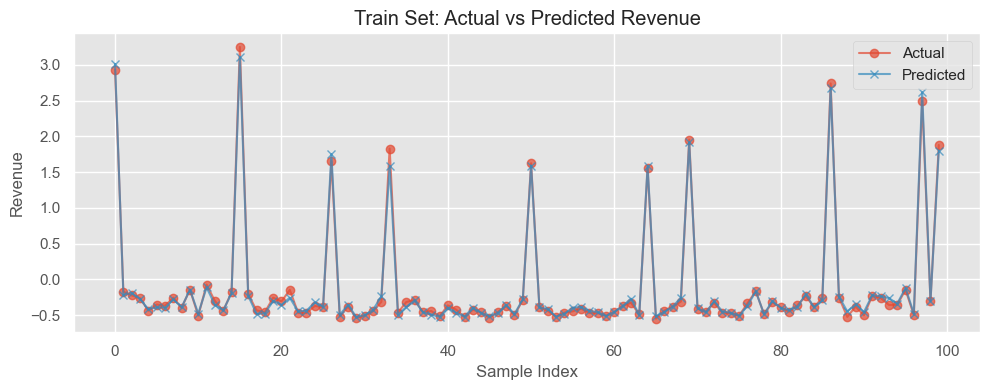

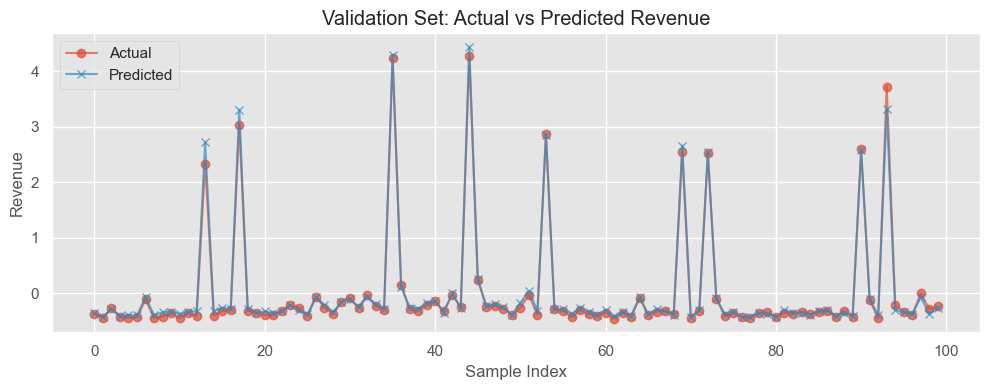

In [75]:
train_xgboost_and_plot_rmse(train_normalized)

# Test 

In [76]:
def process_test_set_for_prediction(test_file_path, train_df, data_path, event_data=None):
    """
    Load and process test set to match training set features
    
    Parameters:
    -----------
    test_file_path : str
        Path to the test CSV file
    train_df : pd.DataFrame
        Training DataFrame to extract reference data from
    data_path : str
        Path to the data directory containing calendar_events.csv
    event_data : pd.DataFrame, optional
        Additional DataFrame with event information (columns: date, event_name)
    
    Returns:
    --------
    pd.DataFrame
        Processed test set with all features matching training set
    """
    
    print("PROCESSING TEST SET FOR PREDICTION")
    print("=" * 50)
    
    # Load test set
    print(f"Loading test set from: {test_file_path}")
    test_df = pd.read_csv(test_file_path)
    
    print(f"Original test set shape: {test_df.shape}")
    print(f"Columns: {list(test_df.columns)}")
    
    # =====================================
    # 0. LOAD CALENDAR EVENTS
    # =====================================
    print(f"\n0. LOADING CALENDAR EVENTS")
    print("-" * 30)
    
    try:
        calendar_path = data_path + "calendar_events.csv"
        calendar = pd.read_csv(calendar_path)
        calendar['date'] = pd.to_datetime(calendar['date'])
        
        print(f"Loaded calendar events from: {calendar_path}")
        print(f"Calendar shape: {calendar.shape}")
        print(f"Date range: {calendar['date'].min()} to {calendar['date'].max()}")
        print(f"Unique events: {calendar['event'].nunique()}")
        print(f"Sample events: {calendar['event'].value_counts().head(3).index.tolist()}")
        
    except FileNotFoundError:
        print(f"Warning: Calendar file not found at {calendar_path}")
        print("Proceeding without calendar events...")
        calendar = pd.DataFrame(columns=['date', 'event'])
    except Exception as e:
        print(f"Error loading calendar: {e}")
        calendar = pd.DataFrame(columns=['date', 'event'])
    
    # =====================================
    # 1. PARSE ID COLUMN
    # =====================================
    print(f"\n1. PARSING ID COLUMN")
    print("-" * 30)
    
    # Split id into store_id and date
    id_parts = test_df['id'].str.split('_', expand=True)
    test_df['store_id'] = id_parts[0].astype(int)
    test_df['date_str'] = id_parts[1]
    
    # Convert date string to datetime
    test_df['date'] = pd.to_datetime(test_df['date_str'], format='%Y%m%d')
    
    # Drop unnecessary columns
    test_df = test_df.drop(['id', 'date_str', 'prediction'], axis=1)
    
    print(f"Extracted store_id and date from id column")
    print(f"Date range: {test_df['date'].min()} to {test_df['date'].max()}")
    print(f"Stores: {test_df['store_id'].nunique()} unique stores")
    print(f"Store IDs: {sorted(test_df['store_id'].unique())}")
    
    # =====================================
    # 2. CREATE BASIC TIME FEATURES
    # =====================================
    print(f"\n2. CREATING BASIC TIME FEATURES")
    print("-" * 30)
    
    # Basic time features
    test_df['dayofweek'] = test_df['date'].dt.dayofweek.astype(float)
    test_df['month'] = test_df['date'].dt.month.astype(float)
    test_df['year'] = test_df['date'].dt.year.astype(float)
    test_df['is_weekend'] = (test_df['date'].dt.dayofweek >= 5).astype(int)
    test_df['quarter'] = test_df['date'].dt.quarter.astype(float)
    
    # Calculate days_since_start (from training set start date)
    train_start_date = train_df['date'].min()
    test_df['days_since_start'] = (test_df['date'] - train_start_date).dt.days.astype(float)
    
    print(f"Created basic time features")
    print(f"Days since start range: {test_df['days_since_start'].min():.0f} to {test_df['days_since_start'].max():.0f}")
    
    # =====================================
    # 3. MERGE CALENDAR EVENT DATA
    # =====================================
    print(f"\n3. PROCESSING CALENDAR EVENT DATA")
    print("-" * 30)
    
    # Start with calendar events
    if len(calendar) > 0:
        # Merge calendar events
        test_df = test_df.merge(calendar[['date', 'event']], on='date', how='left')
        test_df.rename(columns={'event': 'event_name'}, inplace=True)
        calendar_events_found = test_df['event_name'].notna().sum()
        print(f"Merged calendar events: {calendar_events_found} event days found")
        
        if calendar_events_found > 0:
            print(f"Events in test set:")
            event_counts = test_df['event_name'].value_counts()
            for event, count in event_counts.head(10).items():
                print(f"  {event}: {count} days")
    else:
        test_df['event_name'] = np.nan
        print(f"No calendar events available")
    
    # Merge additional event data if provided
    if event_data is not None:
        event_data['date'] = pd.to_datetime(event_data['date'])
        # Merge additional events (will overwrite calendar events if same date)
        test_df = test_df.merge(event_data[['date', 'event_name']], on='date', how='left', suffixes=('', '_additional'))
        
        # Combine events (prefer additional event data over calendar)
        test_df['event_name'] = test_df['event_name_additional'].fillna(test_df['event_name'])
        test_df = test_df.drop('event_name_additional', axis=1)
        print(f"Merged additional event data")
    
    # If still no event data, try to extract from training data
    if test_df['event_name'].notna().sum() == 0:
        if 'event_name' in train_df.columns:
            train_events = train_df[train_df['event_name'].notna()][['date', 'event_name']].drop_duplicates()
            test_df = test_df.merge(train_events, on='date', how='left', suffixes=('', '_train'))
            test_df['event_name'] = test_df['event_name_train'].fillna(test_df['event_name'])
            test_df = test_df.drop('event_name_train', axis=1)
            print(f"Used training set event patterns as fallback")
    
    # Create event flags
    test_df['is_event'] = test_df['event_name'].notna().astype(int)
    
    # Create day before/after event flags
    event_dates = set(test_df[test_df['is_event'] == 1]['date'])
    
    test_df['is_day_before_event'] = 0
    test_df['is_day_after_event'] = 0
    
    for idx, row in test_df.iterrows():
        current_date = row['date']
        
        # Check if day before event
        if (current_date + timedelta(days=1)) in event_dates:
            test_df.at[idx, 'is_day_before_event'] = 1
            
        # Check if day after event
        if (current_date - timedelta(days=1)) in event_dates:
            test_df.at[idx, 'is_day_after_event'] = 1
    
    event_count = test_df['is_event'].sum()
    before_count = test_df['is_day_before_event'].sum()
    after_count = test_df['is_day_after_event'].sum()
    
    print(f"Final event summary:")
    print(f"  Event days: {event_count}")
    print(f"  Day before event: {before_count}")
    print(f"  Day after event: {after_count}")
    
    # =====================================
    # 4. CREATE LAG FEATURES
    # =====================================
    print(f"\n4. CREATING LAG FEATURES")
    print("-" * 30)
    
    # Get last known revenues from training data for each store
    train_last_revenues = train_df.groupby('store_id').apply(
        lambda x: x.nlargest(30, 'date')[['date', 'revenue']].reset_index(drop=True)
    ).reset_index()
    
    # Initialize lag features
    test_df['lag_1'] = np.nan
    test_df['lag_7'] = np.nan
    test_df['lag_14'] = np.nan
    
    print(f"Creating lag features using training data history...")
    
    for store_id in test_df['store_id'].unique():
        store_test = test_df[test_df['store_id'] == store_id].copy()
        store_train_history = train_last_revenues[train_last_revenues['store_id'] == store_id]
        
        if len(store_train_history) > 0:
            # Combine train history with test dates for lag calculation
            history_df = store_train_history[['date', 'revenue']].copy()
            
            for idx, row in store_test.iterrows():
                test_date = row['date']
                
                # Lag 1: 1 day ago
                lag_1_date = test_date - timedelta(days=1)
                lag_1_revenue = history_df[history_df['date'] == lag_1_date]['revenue']
                if not lag_1_revenue.empty:
                    test_df.at[idx, 'lag_1'] = lag_1_revenue.iloc[0]
                
                # Lag 7: 7 days ago
                lag_7_date = test_date - timedelta(days=7)
                lag_7_revenue = history_df[history_df['date'] == lag_7_date]['revenue']
                if not lag_7_revenue.empty:
                    test_df.at[idx, 'lag_7'] = lag_7_revenue.iloc[0]
                
                # Lag 14: 14 days ago
                lag_14_date = test_date - timedelta(days=14)
                lag_14_revenue = history_df[history_df['date'] == lag_14_date]['revenue']
                if not lag_14_revenue.empty:
                    test_df.at[idx, 'lag_14'] = lag_14_revenue.iloc[0]
    
    # Fill missing lags with store averages from training data
    store_averages = train_df.groupby('store_id')['revenue'].mean()
    
    for store_id in test_df['store_id'].unique():
        store_avg = store_averages.get(store_id, train_df['revenue'].mean())
        store_mask = test_df['store_id'] == store_id
        
        test_df.loc[store_mask & test_df['lag_1'].isna(), 'lag_1'] = store_avg
        test_df.loc[store_mask & test_df['lag_7'].isna(), 'lag_7'] = store_avg
        test_df.loc[store_mask & test_df['lag_14'].isna(), 'lag_14'] = store_avg
    
    lag_1_filled = test_df['lag_1'].notna().sum()
    lag_7_filled = test_df['lag_7'].notna().sum()
    lag_14_filled = test_df['lag_14'].notna().sum()
    
    print(f"Lag features created:")
    print(f"  lag_1: {lag_1_filled}/{len(test_df)} filled")
    print(f"  lag_7: {lag_7_filled}/{len(test_df)} filled")
    print(f"  lag_14: {lag_14_filled}/{len(test_df)} filled")
    
    # =====================================
    # 5. CREATE ROLLING FEATURES
    # =====================================
    print(f"\n5. CREATING ROLLING FEATURES")
    print("-" * 30)
    
    # Calculate rolling features using training data + available test data
    test_df['rolling_mean_7'] = np.nan
    test_df['rolling_std_7'] = np.nan
    test_df['rolling_mean_30'] = np.nan
    test_df['rolling_std_30'] = np.nan
    
    for store_id in test_df['store_id'].unique():
        # Get store's training history
        store_train = train_df[train_df['store_id'] == store_id][['date', 'revenue']].copy()
        store_test = test_df[test_df['store_id'] == store_id].copy()
        
        if len(store_train) > 0:
            # Get recent training data for rolling calculations
            recent_train = store_train.nlargest(30, 'date')
            
            # Calculate rolling averages from training data
            train_rolling_7 = recent_train['revenue'].rolling(window=7, min_periods=1).mean().iloc[-1]
            train_rolling_30 = recent_train['revenue'].rolling(window=30, min_periods=1).mean().iloc[-1]
            train_std_7 = recent_train['revenue'].rolling(window=7, min_periods=1).std().iloc[-1]
            train_std_30 = recent_train['revenue'].rolling(window=30, min_periods=1).std().iloc[-1]
            
            # Fill test data with these values (simplified approach)
            store_mask = test_df['store_id'] == store_id
            test_df.loc[store_mask, 'rolling_mean_7'] = train_rolling_7
            test_df.loc[store_mask, 'rolling_std_7'] = train_std_7 if not np.isnan(train_std_7) else 0
            test_df.loc[store_mask, 'rolling_mean_30'] = train_rolling_30
            test_df.loc[store_mask, 'rolling_std_30'] = train_std_30 if not np.isnan(train_std_30) else 0
    
    print(f"Rolling features created using training data history")
    
    # =====================================
    # 6. CREATE STORE-LEVEL FEATURES
    # =====================================
    print(f"\n6. CREATING STORE-LEVEL FEATURES")
    print("-" * 30)
    
    # Calculate store statistics from training data
    store_stats = train_df.groupby('store_id')['revenue'].agg(['mean', 'std']).reset_index()
    store_stats.columns = ['store_id', 'store_avg_revenue', 'store_std_revenue']
    store_stats['store_cv'] = store_stats['store_std_revenue'] / store_stats['store_avg_revenue']
    store_stats['store_cv'] = store_stats['store_cv'].fillna(0)
    
    # Merge store statistics
    test_df = test_df.merge(store_stats, on='store_id', how='left')
    
    # Fill missing store stats with global averages
    global_avg = train_df['revenue'].mean()
    global_std = train_df['revenue'].std()
    global_cv = global_std / global_avg
    
    test_df['store_avg_revenue'] = test_df['store_avg_revenue'].fillna(global_avg)
    test_df['store_std_revenue'] = test_df['store_std_revenue'].fillna(global_std)
    test_df['store_cv'] = test_df['store_cv'].fillna(global_cv)
    
    print(f"Store-level features created")
    print(f"Store avg revenue range: ${test_df['store_avg_revenue'].min():,.0f} - ${test_df['store_avg_revenue'].max():,.0f}")
    
    # =====================================
    # 7. CREATE SPIKE DAY FEATURE
    # =====================================
    print(f"\n7. CREATING SPIKE DAY FEATURE")
    print("-" * 30)
    
    # Calculate store-specific 95th percentiles from training data
    store_spike_thresholds = train_df.groupby('store_id')['revenue'].quantile(0.95)
    
    # For test set, we can't know if it's a spike day since we don't have revenue
    # Set to 0 for all (will be updated after prediction if needed)
    test_df['is_spike_day'] = 0
    
    print(f"Spike day feature initialized (all set to 0 for test set)")
    
    # =====================================
    # 8. CREATE EVENT PERCENTAGE EFFECT FEATURE
    # =====================================
    print(f"\n8. CREATING EVENT PERCENTAGE EFFECT FEATURE")
    print("-" * 30)
    
    # Calculate event effects using training data patterns
    if 'event_name' in test_df.columns and 'event_name' in train_df.columns:
        # Calculate store-specific event effects from training data
        train_event_effects = {}
        
        for store_id in train_df['store_id'].unique():
            store_train_data = train_df[train_df['store_id'] == store_id]
            store_baseline = store_train_data['revenue'].mean()
            
            # Calculate average revenue per event for this store
            store_event_avg = store_train_data.groupby('event_name')['revenue'].mean()
            
            # Calculate percentage effects
            store_effects = {}
            for event_name, avg_revenue in store_event_avg.items():
                if pd.notna(event_name):  # Skip NaN events
                    effect = ((avg_revenue - store_baseline) / store_baseline * 100) if store_baseline > 0 else 0
                    store_effects[event_name] = round(effect, 2)
            
            train_event_effects[store_id] = store_effects
        
        # Apply event effects to test data
        test_df['event'] = 0.0  # Initialize with 0 for no events
        
        for idx, row in test_df.iterrows():
            store_id = row['store_id']
            event_name = row['event_name']
            
            if pd.notna(event_name) and store_id in train_event_effects:
                if event_name in train_event_effects[store_id]:
                    test_df.at[idx, 'event'] = train_event_effects[store_id][event_name]
        
        event_effects_applied = (test_df['event'] != 0).sum()
        print(f"Event percentage effects applied: {event_effects_applied} records")
        print(f"Event effect range: {test_df['event'].min():+.1f}% to {test_df['event'].max():+.1f}%")
        
        # Show summary of events in test set
        test_events = test_df[test_df['event'] != 0].groupby('event_name')['event'].agg(['count', 'mean']).round(2)
        if len(test_events) > 0:
            print(f"\nTest Set Event Summary:")
            print(f"{'Event':<25} {'Count':<8} {'Avg Effect':<12}")
            print("-" * 50)
            for event, stats in test_events.head(10).iterrows():
                print(f"{str(event)[:24]:<25} {stats['count']:<8.0f} {stats['mean']:>+8.1f}%")
    else:
        # No event data available
        test_df['event'] = 0.0
        print(f"No event data available, setting all event effects to 0")
    
    # =====================================
    # 9. CREATE REVENUE CHANGE FEATURE
    # =====================================
    print(f"\n9. CREATING REVENUE CHANGE FEATURE")
    print("-" * 30)
    
    # Calculate revenue change using lag_1
    test_df['revenue_change_1d'] = test_df['lag_1'] * 0  # Initialize as 0 since we don't have current revenue
    
    print(f"Revenue change feature initialized")
    
    # =====================================
    # 10. FINAL ALIGNMENT AND VALIDATION
    # =====================================
    print(f"\n10. FINAL ALIGNMENT AND VALIDATION")
    print("-" * 30)
    
    # Ensure column order matches training set
    train_columns = train_df.columns.tolist()
    if 'revenue' in train_columns:
        train_columns.remove('revenue')  # Remove target column
    
    # Add missing columns with default values
    missing_cols = []
    for col in train_columns:
        if col not in test_df.columns:
            missing_cols.append(col)
            test_df[col] = 0  # Default value
    
    if missing_cols:
        print(f"Added missing columns: {missing_cols}")
    
    # Remove extra columns not in training set
    extra_cols = []
    for col in test_df.columns:
        if col not in train_columns:
            extra_cols.append(col)
    
    if extra_cols:
        test_df = test_df.drop(columns=extra_cols)
        print(f"Removed extra columns: {extra_cols}")
    
    # Reorder columns to match training set
    test_df = test_df[train_columns]
    
    # Final data type alignment
    for col in test_df.columns:
        if col in train_df.columns:
            target_dtype = train_df[col].dtype
            if target_dtype == 'int64' and test_df[col].dtype != 'int64':
                test_df[col] = test_df[col].astype('int64')
            elif target_dtype == 'float64' and test_df[col].dtype != 'float64':
                test_df[col] = test_df[col].astype('float64')
    
    print(f"\nFINAL VALIDATION")
    print("-" * 30)
    print(f"Processed test set shape: {test_df.shape}")
    print(f"Training set shape (excl. revenue): {train_df.drop(columns=['revenue']).shape}")
    print(f"Columns match: {list(test_df.columns) == list(train_df.drop(columns=['revenue']).columns)}")
    print(f"Data types aligned: {(test_df.dtypes == train_df.drop(columns=['revenue']).dtypes).all()}")
    
    # Check for missing values
    missing_summary = test_df.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0]
    
    if len(missing_cols) > 0:
        print(f"\nWarning - Missing values found:")
        for col, count in missing_cols.items():
            print(f"  {col}: {count} missing values")
    else:
        print(f"\nNo missing values found ✓")
    
    print(f"\nTest set ready for prediction!")
    
    return test_df

# Simple usage function
def load_and_process_test_set(test_file_path, train_df, data_path):
    """
    Simple wrapper to load and process test set
    """
    return process_test_set_for_prediction(test_file_path, train_df, data_path)

# Usage Example:
test_processed = load_and_process_test_set(data_path + "forecast_submission.csv", train_normalized, data_path)

PROCESSING TEST SET FOR PREDICTION
Loading test set from: data/forecast_submission.csv
Original test set shape: (1012, 2)
Columns: ['id', 'prediction']

0. LOADING CALENDAR EVENTS
------------------------------
Loaded calendar events from: data/calendar_events.csv
Calendar shape: (162, 2)
Date range: 2011-02-06 00:00:00 to 2016-06-19 00:00:00
Unique events: 34
Sample events: ['SuperBowl', 'Pesach End', 'ValentinesDay']

1. PARSING ID COLUMN
------------------------------
Extracted store_id and date from id column
Date range: 2015-10-01 00:00:00 to 2015-12-31 00:00:00
Stores: 11 unique stores
Store IDs: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]

2. CREATING BASIC TIME FEATURES
------------------------------
Created basic time features
Days since start range: 1692 to 1783

3. PROCESSING CALENDAR EVENT DATA
------------------------------
Merged calendar events: 66 event days found
Events

In [77]:
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   store_id             1012 non-null   int64         
 1   date                 1012 non-null   datetime64[ns]
 2   dayofweek            1012 non-null   float64       
 3   month                1012 non-null   float64       
 4   year                 1012 non-null   float64       
 5   is_weekend           1012 non-null   int64         
 6   quarter              1012 non-null   float64       
 7   days_since_start     1012 non-null   float64       
 8   is_event             1012 non-null   int64         
 9   is_day_before_event  1012 non-null   int64         
 10  is_day_after_event   1012 non-null   int64         
 11  lag_1                1012 non-null   float64       
 12  lag_7                1012 non-null   float64       
 13  lag_14               1012 non-nul

In [78]:
test_processed.head(10)

,store_id,date,dayofweek,month,year,is_weekend,quarter,days_since_start,is_event,is_day_before_event,...,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,store_avg_revenue,store_std_revenue,store_cv,is_spike_day,event
0,0,2015-10-01,3.0,10.0,2015.0,0,4.0,1692.0,0,0,...,3.300948,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
1,0,2015-10-02,4.0,10.0,2015.0,0,4.0,1693.0,0,0,...,3.848685,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
2,0,2015-10-03,5.0,10.0,2015.0,1,4.0,1694.0,0,0,...,5.059160,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
3,0,2015-10-04,6.0,10.0,2015.0,1,4.0,1695.0,0,0,...,5.281739,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
4,0,2015-10-05,0.0,10.0,2015.0,0,4.0,1696.0,0,0,...,3.653316,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
5,0,2015-10-06,1.0,10.0,2015.0,0,4.0,1697.0,0,0,...,3.280656,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
6,0,2015-10-07,2.0,10.0,2015.0,0,4.0,1698.0,0,0,...,3.301289,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
7,0,2015-10-08,3.0,10.0,2015.0,0,4.0,1699.0,0,0,...,3.183106,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
8,0,2015-10-09,4.0,10.0,2015.0,0,4.0,1700.0,0,0,...,3.866863,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
9,0,2015-10-10,5.0,10.0,2015.0,1,4.0,1701.0,0,0,...,4.799773,4.132776,0.490447,3.958521,0.727071,3.029359,0.850167,0.280643,0,0.0
